# 1. Assignment 2

Tom de Wildt (`2068292`)

**Import packages**

In [1]:
from collections import Counter
import math
import re

from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from tqdm import tqdm

from FuzzyTM import FuzzyTM, FLSA, FLSA_W, FLSA_V, FLSA_E
from gensim.models.coherencemodel import CoherenceModel
from gensim.models import LdaModel, LsiModel
from gensim.corpora import Dictionary
from wordcloud import WordCloud

import matplotlib.colors as mcols
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

**Settings**

In [2]:
# Folders
DATASET_FOLDER = "../data/"

# Datasets
NEWS_DATASET_FILE = "us_equities_news.csv"

# Settings
RANDOM_SEED = 42

# Other
TEXT_START = "\033[1m"
TEXT_END = "\033[0m"

In [3]:
np.random.seed(RANDOM_SEED)
tqdm.pandas()

## 1.1 Import data

In [4]:
%%time
df_us_equities_news = pd.read_csv(DATASET_FOLDER + NEWS_DATASET_FILE)

CPU times: user 4.72 s, sys: 298 ms, total: 5.02 s
Wall time: 5.02 s


## 1.2 Preprocess data

### 1.2.1 Prepare data

**Rename columns**

In [5]:
df_us_equities_news = df_us_equities_news.rename(columns={"release_date": "date"})

**Set data types**

In [6]:
df_us_equities_news["id"] = df_us_equities_news["id"].astype(int)
df_us_equities_news["ticker"] = df_us_equities_news["ticker"].astype("category")
df_us_equities_news["title"] = df_us_equities_news["title"].astype(str)
df_us_equities_news["category"] = df_us_equities_news["category"].astype("category")
df_us_equities_news["content"] = df_us_equities_news["content"].astype(str)
df_us_equities_news["date"] = pd.to_datetime(df_us_equities_news["date"])
df_us_equities_news["provider"] = df_us_equities_news["provider"].astype("category")
df_us_equities_news["url"] = df_us_equities_news["url"].astype(str)
df_us_equities_news["article_id"] = df_us_equities_news["article_id"].astype(int)

### 1.2.2 Subset data

In [7]:
df_us_equities_news = df_us_equities_news[df_us_equities_news["title"].str.contains("Apple")]

### 1.2.3 Clean data

**Remove duplicate rows**

In [8]:
print(f"Rows (Before): {df_us_equities_news.shape[0]}")
df_us_equities_news = df_us_equities_news.drop_duplicates(subset=["content"])
print(f"Rows (After): {df_us_equities_news.shape[0]}")

Rows (Before): 5117
Rows (After): 5109


**Remove null values**

In [9]:
print(f"Rows (Before): {df_us_equities_news.shape[0]}")
df_us_equities_news = df_us_equities_news[
    (df_us_equities_news["title"] != "nan")
    & (df_us_equities_news["content"] != "nan")
]
print(f"Rows (After): {df_us_equities_news.shape[0]}")

Rows (Before): 5109
Rows (After): 5109


**Remove unused columns**

In [10]:
df_us_equities_news = df_us_equities_news.drop(columns=["id", "url", "article_id"])

**Reset index**

In [11]:
df_us_equities_news = df_us_equities_news.reset_index(drop=True)

**Sort rows**

In [12]:
df_us_equities_news = df_us_equities_news.sort_values("date")

## 1.3 Explore data

### 1.3.1 Inspect rows

In [13]:
df_us_equities_news.head(10)

ticker                                              title category  \
5000   MSFT  COLUMN What Apple loses without Steve  Eric Au...     news   
4999   MSFT  UPDATE 2 Microsoft to open own stores  take on...     news   
5065   DELL  UPDATE 5 Apple halves iPhone to  99  trims Mac...     news   
5096    MMM  US STOCKS McDonald s  Apple drag down Wall Street     news   
5055    NYT  CHRONOLOGY Key dates in health saga of Apple s...     news   
5053   SPGI  US STOCKS Wall St climbs on Caterpillar  Apple...     news   
785      KO  US STOCKS Apple  Starbucks lift Nasdaq  Dow  S...     news   
786      KO  US STOCKS Nasdaq up on Apple  Starbucks  eBay ...     news   
784      KO  US STOCKS Apple  Starbucks lift Nasdaq  Dow lo...     news   
5024     BA  US STOCKS Apple helps Nasdaq  while banks curb...     news   

                                                content       date provider  
5000     Eric Auchard is a Reuters columnist  The op... 2009-01-15  Reuters  
4999   Adds details on stores  background on retaili... 2009-02-12  Reuters  
5065    Apple cuts entry iPhone price to  99  reveal... 2009-06-08  Reuters  
5096    McDonald s shares fall after May sales\n   A... 2009-06-08  Reuters  
5055  June 30  Reuters    Apple Inc  Co founder and ... 2009-06-29  Reuters  
5053    Caterpillar sees tough Q3  but stock lifts D... 2009-07-21  Reuters  
785     Apple  Starbucks lift Nasdaq on solid profit... 2009-07-22  Reuters  
786     Apple  Starbucks lift Nasdaq on solid profit... 2009-07-22  Reuters  
784     Apple s stock up after results late Tuesday\... 2009-07-22  Reuters  
5024    Apple s stock up 4 percent after results lat... 2009-07-22  Reuters

### 1.3.2 Inspect data types

In [14]:
df_us_equities_news.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5109 entries, 5000 to 5105
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   ticker    5109 non-null   category      
 1   title     5109 non-null   object        
 2   category  5109 non-null   category      
 3   content   5109 non-null   object        
 4   date      5109 non-null   datetime64[ns]
 5   provider  5109 non-null   category      
dtypes: category(3), datetime64[ns](1), object(2)
memory usage: 263.2+ KB


### 1.3.3 Inspect basic statistics

In [15]:
df_us_equities_news.describe(include="all")

/tmp/ipykernel_439270/2992659162.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df_us_equities_news.describe(include="all")


ticker           title category  \
count    5109            5109     5109   
unique    102            5085        2   
top      AAPL  Apple Falls 4      news   
freq     4196               3     2920   
first     NaN             NaN      NaN   
last      NaN             NaN      NaN   

                                                  content  \
count                                                5109   
unique                                               5109   
top        Eric Auchard is a Reuters columnist  The op...   
freq                                                    1   
first                                                 NaN   
last                                                  NaN   

                       date provider  
count                  5109     5109  
unique                 1660      224  
top     2020-01-28 00:00:00  Reuters  
freq                     44     1583  
first   2009-01-15 00:00:00      NaN  
last    2020-02-11 00:00:00      NaN

### 1.3.4 Inspect missing data

In [16]:
percent_missing = df_us_equities_news.isnull().sum() * 100 / len(df_us_equities_news)

df_us_equities_news_missing_data = pd.DataFrame({"PERCENT_MISSING": percent_missing}, index=df_us_equities_news.columns)
df_us_equities_news_missing_data

PERCENT_MISSING
ticker                0.0
title                 0.0
category              0.0
content               0.0
date                  0.0
provider              0.0

### 1.3.5 Inspect document & word statistics

In [17]:
ret = RegexpTokenizer(r"\w+")
counter = Counter([word for word_list in df_us_equities_news["content"].apply(ret.tokenize) for word in word_list])

total_words = sum(counter.values())
total_unique_words = len(counter)
total_unique_documents = len(df_us_equities_news)
average_words_per_document = total_words / total_unique_documents

print(TEXT_START + "Total Words: " + TEXT_END + str(total_words))
print(TEXT_START + "Total Unique Words: " + TEXT_END + str(total_unique_words))
print(TEXT_START + "Total Documents: " + TEXT_END + str(total_unique_documents))
print(TEXT_START + "Total Unique Documents: " + TEXT_END + str(total_unique_documents))
print(TEXT_START + "Average Words per Document: " + TEXT_END + str(average_words_per_document))

Total Words: 2613570
Total Unique Words: 43726
Total Documents: 5109
Total Unique Documents: 5109
Average Words per Document: 511.5619495008808


## 1.4 Preprocess text

### 1.4.1 Consolidate text

In [18]:
# Concat title and content
df_us_equities_news["text"] = df_us_equities_news["title"] + " " + df_us_equities_news["content"]

# Remove unused columns
df_us_equities_news = df_us_equities_news.drop(columns=["title", "content"])

### 1.4.2 Remove EOL characters

In [19]:
df_us_equities_news["text"] = df_us_equities_news["text"].progress_apply(lambda x: re.sub(r"(\n|\t|\r)", "", x))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5109/5109 [00:00<00:00, 62524.29it/s]


### 1.4.3 Remove other characters

In [20]:
df_us_equities_news["text"] = df_us_equities_news["text"].progress_apply(lambda x: re.sub(r"[^a-zA-ZÀ-ȕ]", " ", x))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5109/5109 [00:00<00:00, 9654.92it/s]


### 1.4.4 Remove excessive spaces

In [21]:
df_us_equities_news["text"] = df_us_equities_news["text"].progress_apply(lambda x: re.sub(r"\s{2,}", " ", x))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5109/5109 [00:00<00:00, 17713.12it/s]


### 1.4.5 Convert to lowercase

In [22]:
df_us_equities_news["text"] = df_us_equities_news["text"].progress_apply(lambda x: x.lower())

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5109/5109 [00:00<00:00, 334082.18it/s]


### 1.4.6 Remove single letters, stopwords and lemmatize

In [23]:
words = set(stopwords.words("english"))
ret = RegexpTokenizer(r"\w+")
wnl = WordNetLemmatizer()

df_us_equities_news["text"] = df_us_equities_news["text"].progress_apply(lambda x: " ".join(wnl.lemmatize(t) for t in ret.tokenize(x) if t not in words and len(t) > 1))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5109/5109 [00:05<00:00, 971.90it/s]


## 1.5 Modeling

### 1.5.1 Analysis helpers

* Scores:
    * Coherence Score: intra-topic quality, captures how well the words within each topic support each other.
    * Diversity Score: inter-topic-quality, shows how diverse each topic is (whether there is word overlap between topics).
    * Interpretability Score: combines both metrics and is calculated as the product between coherence and diversity.

In [24]:
def print_topics(model):
    topics = model.show_topics(num_topics=model.num_topics)

    for topic, content in topics:
        content = zip(
            re.findall(r'"(.*?)"', content),
            [float(score) for score in re.findall(r"-?\d+\.\d+", content)],
        )

        print(f"Topic {topic}: " + str([(word, round(score, 4)) for word, score in content]))


def print_scores(model, documents):
    if isinstance(model, FuzzyTM):
        topics = model.show_topics(representation="words")

        coherence = model.get_coherence_score(input_file=documents, topics=topics)
        diversity = model.get_diversity_score(topics=topics)
        interpretability = model.get_interpretability_score(input_file=documents, topics=topics)
    else:
        dictionary = Dictionary(documents)
        topics = [[word for word, score in words] for topic, words in model.show_topics(num_topics=model.num_topics, formatted=False)]
        unique_words = set()
        total_words = 0

        for words in topics:
            unique_words.update(words)
            total_words += len(words)

        coherence = CoherenceModel(model=model, texts=documents, dictionary=dictionary, coherence="c_v").get_coherence()            
        diversity = len(unique_words) / total_words
        interpretability = coherence * diversity

    print(f"Coherence: {coherence}")
    print(f"Diversity: {diversity}")
    print(f"Interpretability: {interpretability}")


def plot_topics(model, figsize=(24, 12)):
    topics = model.show_topics(num_topics=model.num_topics)
    num_columns = 5
    num_rows = math.ceil(len(topics) / num_columns)

    colors = [color for _, color in mcols.TABLEAU_COLORS.items()]
    wordcloud = WordCloud(
        width=2500,
        height=1800,
        max_words=10,
        colormap="tab10",
        color_func=lambda *args, **kwargs: colors[idx % len(colors)],
        background_color="white",
        prefer_horizontal=1.0,
    )

    fig, axes = plt.subplots(num_rows, num_columns, figsize=figsize, sharex=True, sharey=True)
    for idx, ax in enumerate(axes.flatten()):
        if idx > len(topics) - 1:
            break

        fig.add_subplot(ax)
        
        topic = zip(
            re.findall(r'"(.*?)"', topics[idx][1]),
            [float(score) for score in re.findall(r"-?\d+\.\d+", topics[idx][1])],
        )
        wordcloud.generate_from_frequencies({word: abs(value) for word, value in topic})

        plt.gca().imshow(wordcloud)
        plt.gca().set_title(f"Topic {idx}", fontsize=14, fontweight="bold")
        plt.gca().axis("off")

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.margins(x=0, y=0)
    plt.tight_layout()
    plt.axis("off")
    plt.show()


def plot_graph(func, documents, start, end, step, **kwargs):
    options = range(start, end, step)
    coherence_scores = []
    diversity_scores = []
    interpretability_scores = []

    for num_topics in tqdm(options):
        model = func(documents, num_topics=num_topics, **kwargs)

        if isinstance(model, FuzzyTM):
            topics = model.show_topics(representation="words")
            coherence = model.get_coherence_score(input_file=documents, topics=topics)
            diversity = model.get_diversity_score(topics=topics)
            interpretability = model.get_interpretability_score(input_file=documents, topics=topics)
        else:
            dictionary = Dictionary(documents)
            topics = [[word for word, score in words] for topic, words in model.show_topics(num_topics=model.num_topics, formatted=False)]
            unique_words = set()
            total_words = 0

            for words in topics:
                unique_words.update(words)
                total_words += len(words)

            coherence = CoherenceModel(model=model, texts=documents, dictionary=dictionary, coherence="c_v").get_coherence()
            diversity = len(unique_words) / total_words
            interpretability = coherence * diversity

        coherence_scores.append(coherence)
        diversity_scores.append(diversity)
        interpretability_scores.append(interpretability)

    plt.figure(figsize=(24, 6))
    plt.plot(options, coherence_scores, marker=".", label="coherence")
    plt.plot(options, diversity_scores, marker=".", label="diversity")
    plt.plot(options, interpretability_scores, marker=".", label="interpretability")
    plt.xlabel("Number of Topics")
    plt.ylabel("Score")
    plt.legend()
    plt.show()

### 1.5.2 Document helpers

In [25]:
def remove_from_documents(documents, exclude):
    return [[word for word in document if word not in exclude] for document in documents]

### 1.5.3 Modeling helpers

* LSA:
    * `num_topics`: number of topics.
    * `chunksize`: number of documents to be used in each training chunk.
    * `decay`: weight of existing observations relatively to new ones.
* LDA:
    * `num_topics`: number of topics.
    * `alpha`: a-priori belief on document-topic distribution
    * `chunksize`: number of documents to be used in each training chunk.
    * `decay`: weight what percentage of the previous lambda value is forgotten when each new document is exmined.
    * `passes`: number of passes through the corpus during training.
    * `update_every`: number of documents to be iterated through for each update.
* FuzzyTM:
    * `num_topics`: number of topics you want the model to find.
    * `num_words`: number of words (top-n) per topic used to represent that topic.
    * `variant`: which variant of FLSA to use.
    * `word_weighting`: the method used for global term weighting.
    * `cluster_method`: the (fuzzy) cluster method to be used.

In [26]:
def create_lsa_model(documents, num_topics=10, chunksize=20000, decay=1.0):
    dictionary = Dictionary(documents)
    corpus = [dictionary.doc2bow(document) for document in documents]

    model = LsiModel(
        corpus,
        id2word=dictionary,
        num_topics=num_topics,
        chunksize=chunksize,
        decay=decay,
        random_seed=RANDOM_SEED,
    )

    return model


def create_lda_model(documents, num_topics=10, alpha="symmetric", chunksize=2000, decay=0.5, passes=1, update_every=1):
    dictionary = Dictionary(documents)
    corpus = [dictionary.doc2bow(document) for document in documents]

    model = LdaModel(
        corpus,
        id2word=dictionary,
        num_topics=num_topics,
        alpha=alpha,
        chunksize=chunksize,
        decay=decay,
        passes=passes,
        update_every=update_every,
        random_state=RANDOM_SEED,
    )

    return model


def create_fuzzytm_model(documents, num_topics=10, num_words=20, variant=None, word_weighting="normal", cluster_method="fcm"):
    if variant is None:
        model = FLSA(
            documents,
            num_topics=num_topics,
            num_words=num_words,
            word_weighting=word_weighting,
            cluster_method=cluster_method,
        )
    elif variant == "W":
        model = FLSA_W(
            documents,
            num_topics=num_topics,
            num_words=num_words,
            word_weighting=word_weighting,
            cluster_method=cluster_method,
        )
    elif variant == "V":
        model = FLSA_V(
            documents,
            map_file=None, # TODO(tomdewildt): figure out what to provide as map_file?
            num_topics=num_topics,
            num_words=num_words,
            cluster_method=cluster_method,
        )
    elif variant == "E":
        model = FLSA_E(
            documents,
            num_topics=num_topics,
            num_words=num_words,
            cluster_method=cluster_method,
        )

    pwgt, ptgd = model.get_matrices()

    return model

### 1.5.4 LSA modeling

In [27]:
documents = df_us_equities_news["text"].str.split(" ").tolist()

**Find num topics**

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [02:56<00:00,  9.81s/it]


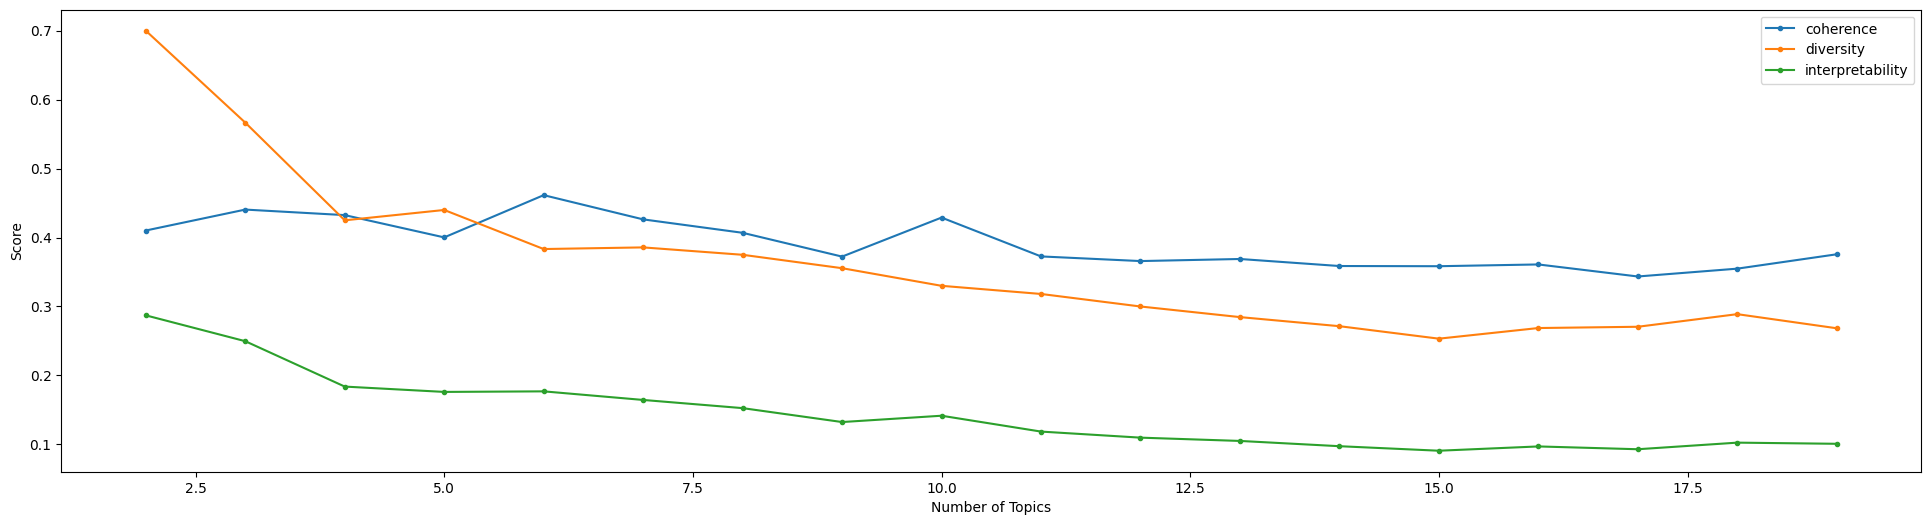

In [28]:
plot_graph(create_lsa_model, documents, 2, 20, 1)

#### 1.5.4.1 Iteration 1

In [29]:
%%time
lsa_model = create_lsa_model(documents, num_topics=5)

CPU times: user 8.75 s, sys: 6.44 s, total: 15.2 s
Wall time: 2.9 s


In [30]:
print_topics(lsa_model)

Topic 0: [('apple', 0.573), ('year', 0.238), ('company', 0.235), ('stock', 0.209), ('market', 0.158), ('zacks', 0.153), ('iphone', 0.15), ('billion', 0.144), ('share', 0.134), ('quarter', 0.126)]
Topic 1: [('apple', -0.599), ('zacks', 0.321), ('stock', 0.29), ('earnings', 0.209), ('investment', 0.187), ('iphone', -0.168), ('said', -0.149), ('year', 0.122), ('market', 0.121), ('estimate', 0.115)]
Topic 2: [('billion', -0.438), ('revenue', -0.315), ('zacks', 0.257), ('share', -0.246), ('quarter', -0.236), ('year', -0.213), ('investment', 0.213), ('percent', -0.166), ('stock', 0.162), ('cent', -0.134)]
Topic 3: [('percent', 0.307), ('earnings', -0.262), ('said', 0.256), ('zacks', -0.214), ('year', -0.213), ('estimate', -0.2), ('iphone', -0.197), ('market', 0.193), ('quarter', -0.191), ('stock', 0.183)]
Topic 4: [('earnings', -0.416), ('billion', 0.267), ('zacks', 0.21), ('company', 0.195), ('service', 0.178), ('aapl', -0.172), ('price', -0.161), ('week', -0.154), ('investment', 0.135), ('

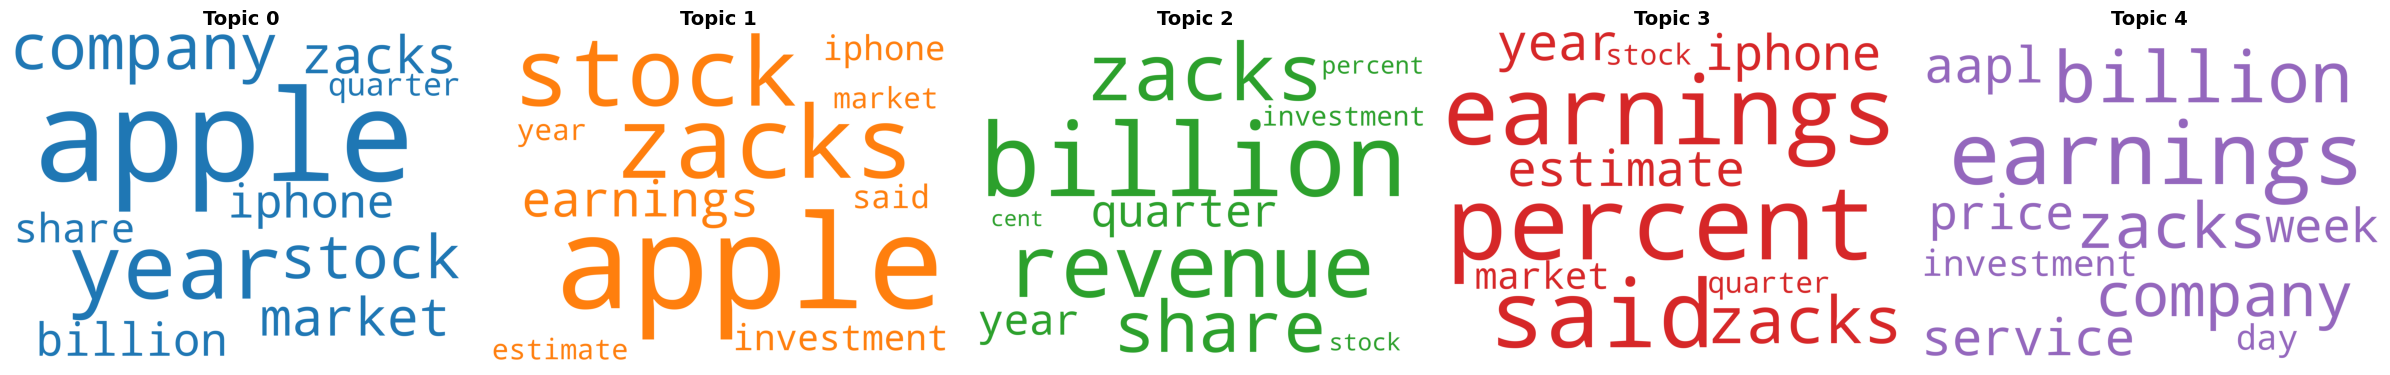

In [31]:
plot_topics(lsa_model)

In [32]:
print_scores(lsa_model, documents)

Coherence: 0.4002193716288236
Diversity: 0.44
Interpretability: 0.1760965235166824


#### 1.5.4.2 Iteration 2

* We observe that `apple`, `billion` and `earnings` occur in the top two for at least two of the topics → we remove these words, because in the case of `billion` and `earnings` they are too generic and `apple` occurs in too much of the documents.
* We observe that `year` and `zacks` occurs in almost all the topics, albeit at different positions → we remove these words, because they are too generic.

In [33]:
documents = remove_from_documents(documents, ["apple", "billion", "earnings", "year", "zacks"])

In [34]:
%%time
lsa_model = create_lsa_model(documents, num_topics=5)

CPU times: user 8.5 s, sys: 6.28 s, total: 14.8 s
Wall time: 2.87 s


In [35]:
print_topics(lsa_model)

Topic 0: [('company', 0.316), ('stock', 0.307), ('market', 0.222), ('share', 0.185), ('iphone', 0.171), ('quarter', 0.168), ('nasdaq', 0.164), ('revenue', 0.159), ('investment', 0.138), ('new', 0.128)]
Topic 1: [('iphone', 0.389), ('stock', -0.377), ('said', 0.355), ('investment', -0.259), ('new', 0.156), ('sale', 0.139), ('china', 0.129), ('research', -0.126), ('phone', 0.116), ('percent', 0.108)]
Topic 2: [('revenue', -0.391), ('quarter', -0.322), ('share', -0.321), ('investment', 0.194), ('percent', -0.169), ('cent', -0.162), ('expected', -0.148), ('said', 0.146), ('eps', -0.132), ('ago', -0.129)]
Topic 3: [('percent', 0.372), ('iphone', -0.369), ('said', 0.26), ('sale', -0.198), ('quarter', -0.192), ('share', 0.182), ('service', -0.181), ('estimate', -0.157), ('growth', -0.153), ('market', 0.13)]
Topic 4: [('company', 0.369), ('iphone', -0.297), ('price', -0.224), ('stock', -0.224), ('service', 0.183), ('revenue', 0.18), ('aapl', -0.174), ('said', 0.156), ('week', -0.132), ('day', 

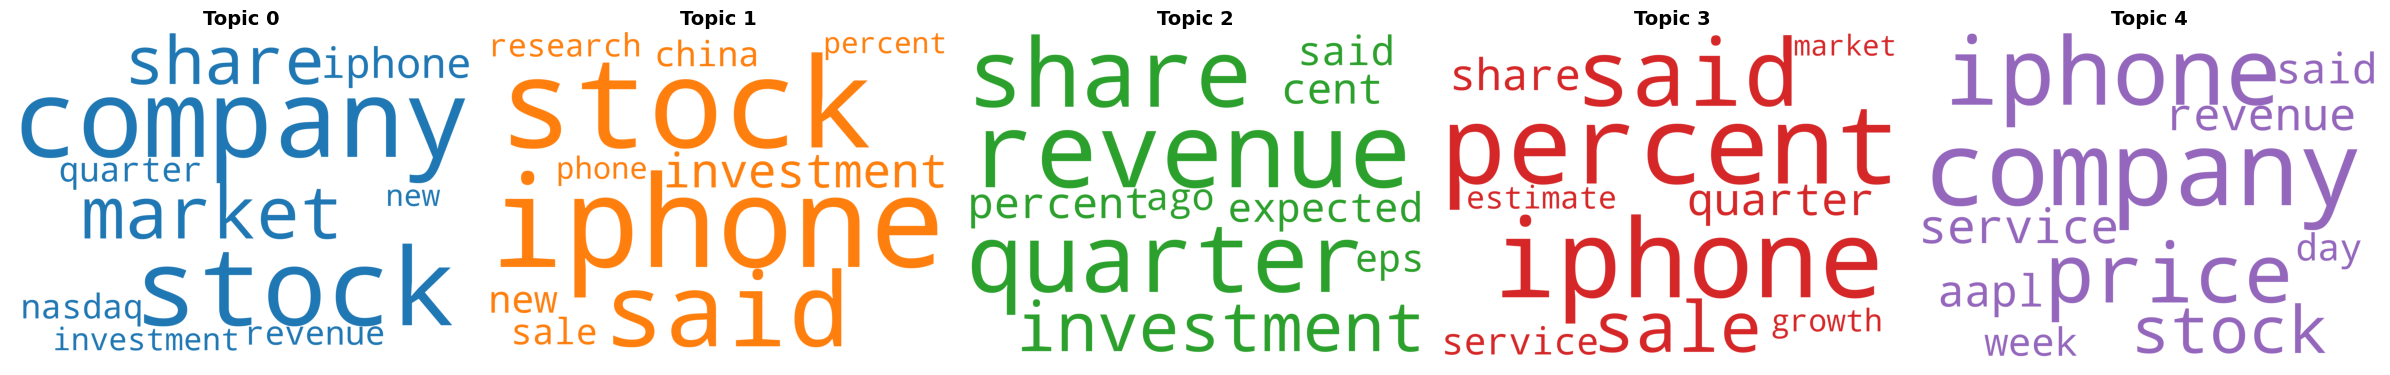

In [36]:
plot_topics(lsa_model)

In [37]:
print_scores(lsa_model, documents)

Coherence: 0.35036929401697864
Diversity: 0.54
Interpretability: 0.1891994187691685


#### 1.5.4.3 Iteration 3

* We observe that our `diversity` score goes up, but our `coherence` score goes down → we increase the number of topics by `5` to increase our `coherence` score.

In [38]:
%%time
lsa_model = create_lsa_model(documents, num_topics=10)

CPU times: user 9.63 s, sys: 7.59 s, total: 17.2 s
Wall time: 2.96 s


In [39]:
print_topics(lsa_model)

Topic 0: [('company', 0.316), ('stock', 0.307), ('market', 0.222), ('share', 0.185), ('iphone', 0.171), ('quarter', 0.168), ('nasdaq', 0.164), ('revenue', 0.159), ('investment', 0.138), ('new', 0.128)]
Topic 1: [('iphone', 0.389), ('stock', -0.377), ('said', 0.355), ('investment', -0.259), ('new', 0.156), ('sale', 0.139), ('china', 0.129), ('research', -0.126), ('phone', 0.116), ('percent', 0.108)]
Topic 2: [('revenue', 0.391), ('quarter', 0.322), ('share', 0.321), ('investment', -0.194), ('percent', 0.169), ('cent', 0.162), ('expected', 0.148), ('said', -0.146), ('eps', 0.132), ('ago', 0.129)]
Topic 3: [('percent', -0.372), ('iphone', 0.369), ('said', -0.26), ('sale', 0.197), ('quarter', 0.192), ('share', -0.182), ('service', 0.181), ('estimate', 0.157), ('growth', 0.153), ('market', -0.13)]
Topic 4: [('company', -0.369), ('iphone', 0.297), ('stock', 0.224), ('price', 0.224), ('service', -0.183), ('revenue', -0.18), ('aapl', 0.174), ('said', -0.156), ('week', 0.132), ('day', 0.121)]
T

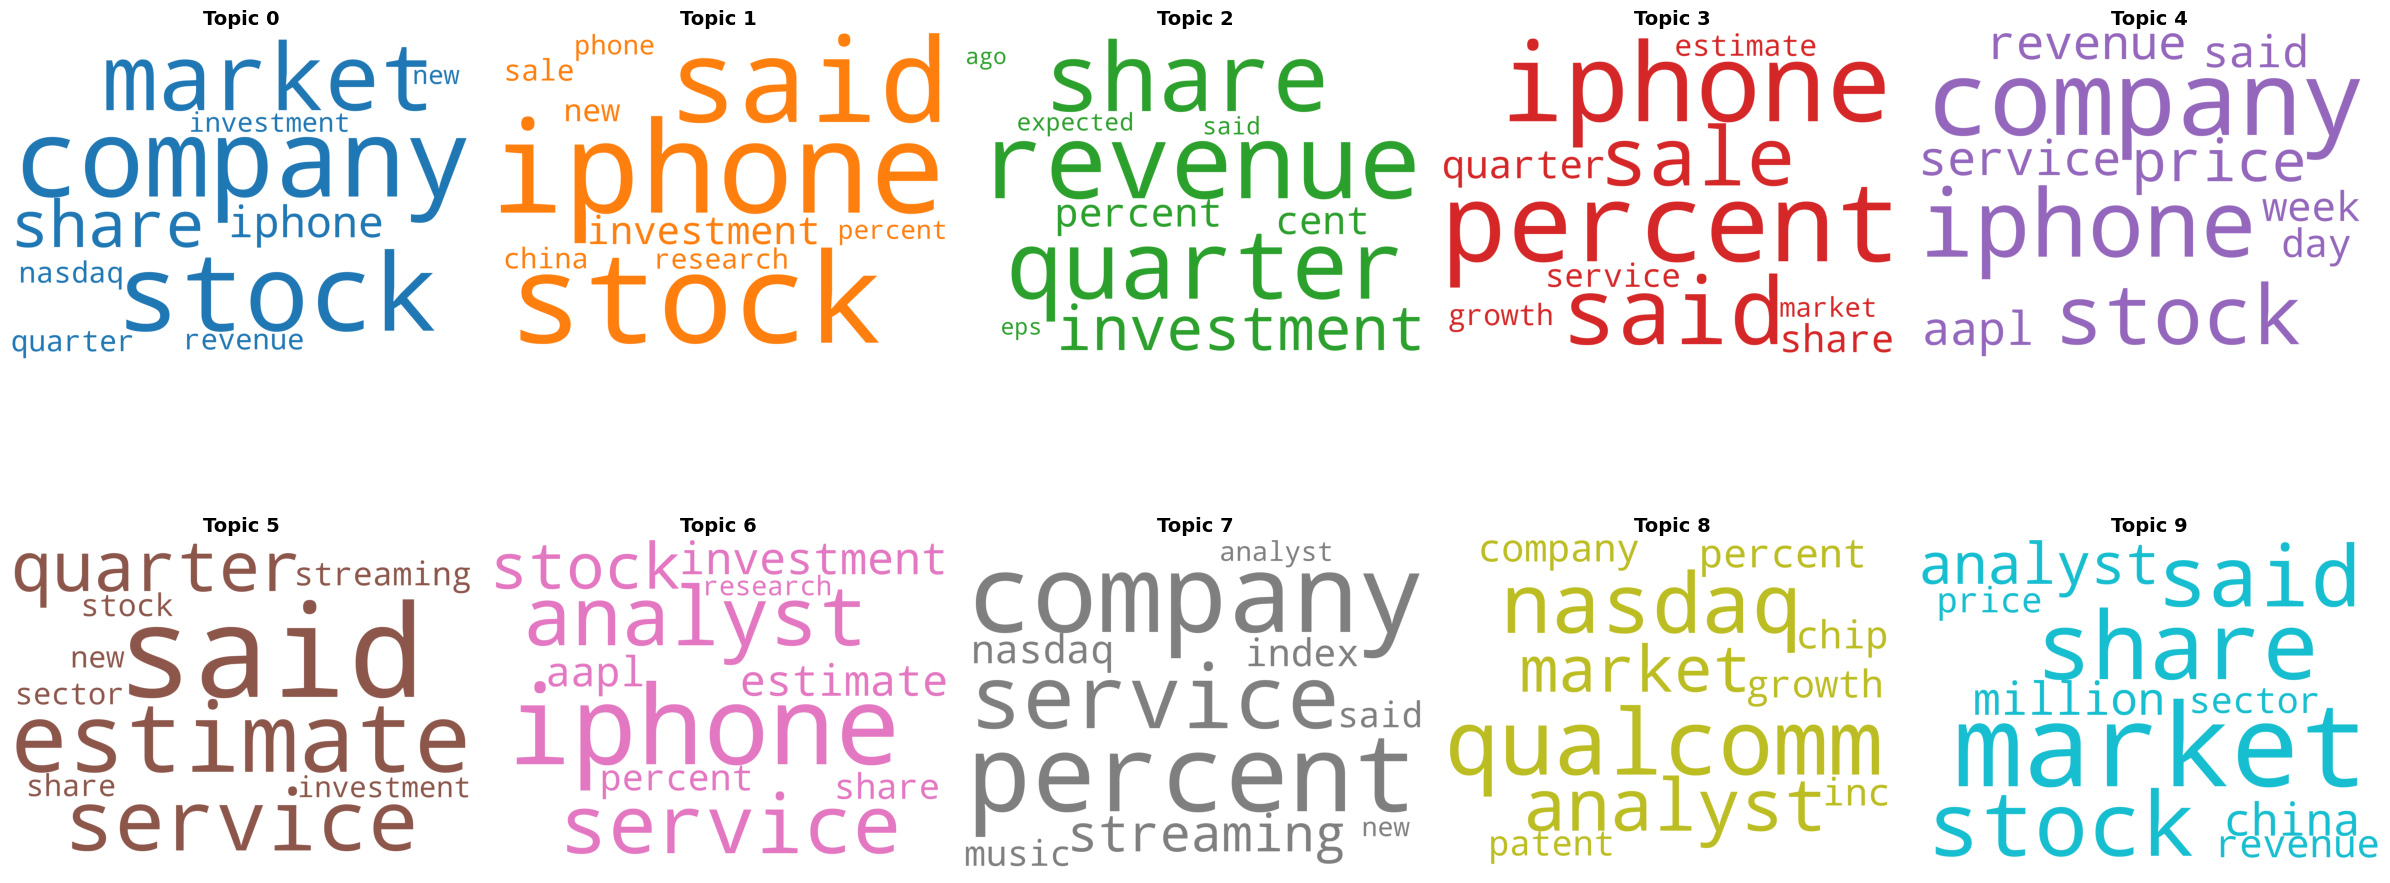

In [40]:
plot_topics(lsa_model)

In [41]:
print_scores(lsa_model, documents)

Coherence: 0.40269784843159273
Diversity: 0.37
Interpretability: 0.14899820391968932


#### 1.5.4.4 Iteration 4

* We observe that our `diversity` score went down drastically and our `coherence` score only increased marginally → we decrease the number of topics by `3` to increase our `diversity` score.

In [42]:
%%time
lsa_model = create_lsa_model(documents, num_topics=7)

CPU times: user 9.7 s, sys: 10.2 s, total: 19.9 s
Wall time: 3.31 s


In [43]:
print_topics(lsa_model)

Topic 0: [('company', 0.316), ('stock', 0.307), ('market', 0.222), ('share', 0.185), ('iphone', 0.171), ('quarter', 0.168), ('nasdaq', 0.164), ('revenue', 0.159), ('investment', 0.138), ('new', 0.128)]
Topic 1: [('iphone', 0.389), ('stock', -0.377), ('said', 0.355), ('investment', -0.259), ('new', 0.156), ('sale', 0.139), ('china', 0.129), ('research', -0.126), ('phone', 0.116), ('percent', 0.108)]
Topic 2: [('revenue', -0.391), ('quarter', -0.322), ('share', -0.321), ('investment', 0.194), ('percent', -0.169), ('cent', -0.162), ('expected', -0.148), ('said', 0.146), ('eps', -0.132), ('ago', -0.129)]
Topic 3: [('percent', -0.372), ('iphone', 0.369), ('said', -0.26), ('sale', 0.198), ('quarter', 0.192), ('share', -0.182), ('service', 0.181), ('estimate', 0.157), ('growth', 0.153), ('market', -0.13)]
Topic 4: [('company', 0.369), ('iphone', -0.297), ('price', -0.224), ('stock', -0.224), ('service', 0.183), ('revenue', 0.18), ('aapl', -0.174), ('said', 0.156), ('week', -0.132), ('day', -0

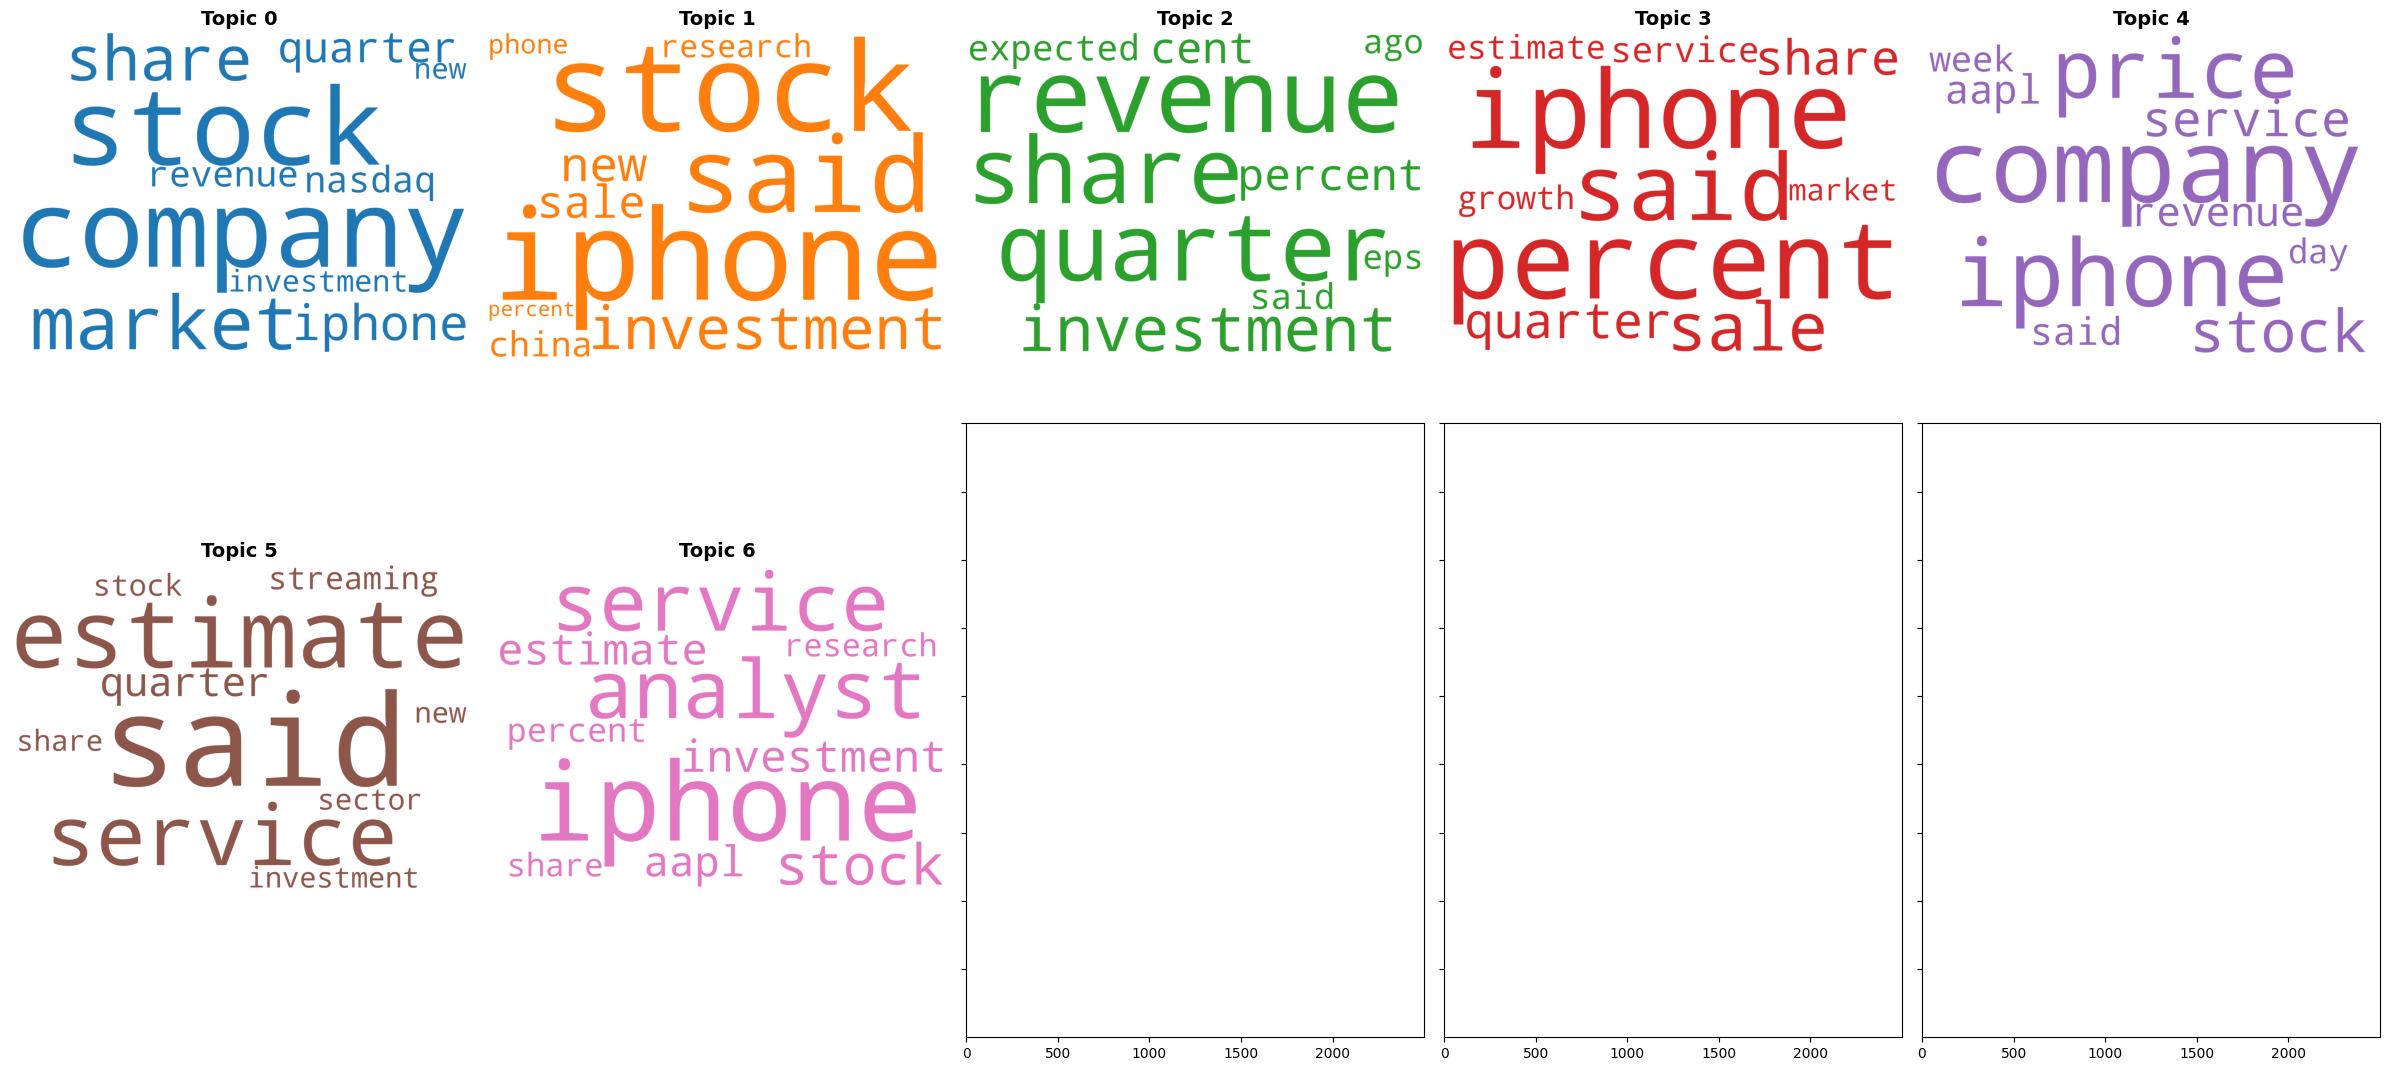

In [44]:
plot_topics(lsa_model)

In [45]:
print_scores(lsa_model, documents)

Coherence: 0.3585614986605589
Diversity: 0.42857142857142855
Interpretability: 0.1536692137116681


#### 1.5.4.5 Iteration 5

* We observe that our `diversity` score improved and `coherence` score only decreased marginally → we therefore further decrease the number of topics by `1` to increase our `diversity` score.

In [46]:
%%time
lsa_model = create_lsa_model(documents, num_topics=6)

CPU times: user 8.72 s, sys: 7.49 s, total: 16.2 s
Wall time: 2.78 s


In [47]:
print_topics(lsa_model)

Topic 0: [('company', 0.316), ('stock', 0.307), ('market', 0.222), ('share', 0.185), ('iphone', 0.171), ('quarter', 0.168), ('nasdaq', 0.164), ('revenue', 0.159), ('investment', 0.138), ('new', 0.128)]
Topic 1: [('iphone', 0.389), ('stock', -0.377), ('said', 0.355), ('investment', -0.259), ('new', 0.156), ('sale', 0.139), ('china', 0.129), ('research', -0.126), ('phone', 0.116), ('percent', 0.108)]
Topic 2: [('revenue', 0.391), ('quarter', 0.322), ('share', 0.321), ('investment', -0.194), ('percent', 0.169), ('cent', 0.161), ('expected', 0.148), ('said', -0.146), ('eps', 0.132), ('ago', 0.129)]
Topic 3: [('percent', 0.372), ('iphone', -0.369), ('said', 0.26), ('sale', -0.197), ('quarter', -0.192), ('share', 0.182), ('service', -0.181), ('estimate', -0.157), ('growth', -0.153), ('market', 0.13)]
Topic 4: [('company', 0.369), ('iphone', -0.297), ('price', -0.224), ('stock', -0.224), ('service', 0.183), ('revenue', 0.18), ('aapl', -0.174), ('said', 0.156), ('week', -0.132), ('day', -0.12)

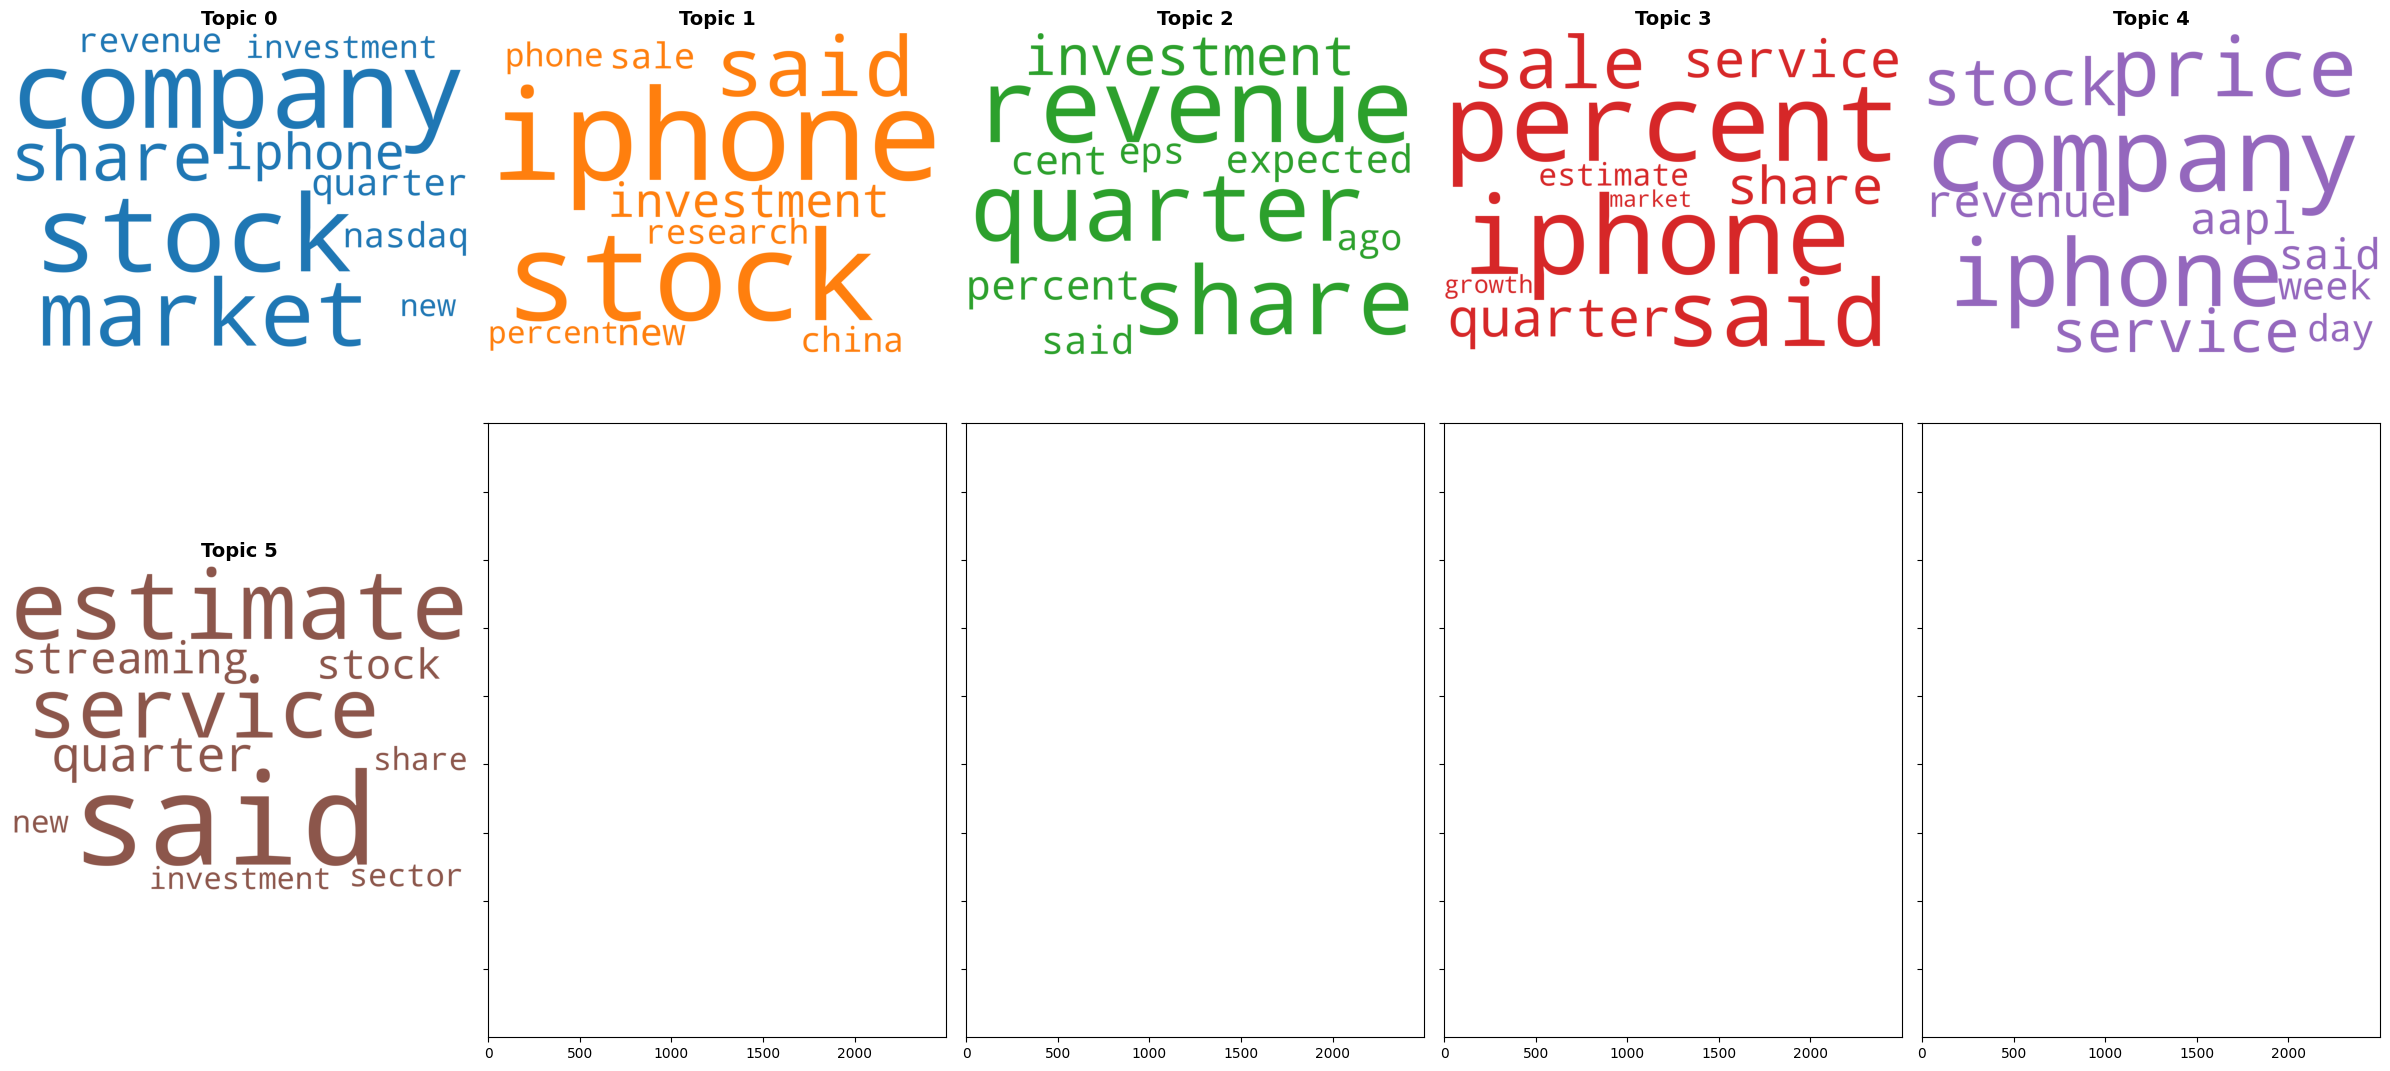

In [48]:
plot_topics(lsa_model)

In [49]:
print_scores(lsa_model, documents)

Coherence: 0.3968478498878574
Diversity: 0.48333333333333334
Interpretability: 0.1918097941124644


#### 1.5.4.6 Iteration 6

* We observe the highest `interpretability` score yet → the number of topics seems quite set for now.
* Two of the topics contain `company` and `stock` in high positions → so let's remove these words.

In [50]:
documents = remove_from_documents(documents, ["company", "stock"])

In [51]:
%%time
lsa_model = create_lsa_model(documents, num_topics=6)

CPU times: user 8.92 s, sys: 7.02 s, total: 15.9 s
Wall time: 2.82 s


In [52]:
print_topics(lsa_model)

Topic 0: [('market', 0.245), ('share', 0.203), ('iphone', 0.202), ('quarter', 0.189), ('nasdaq', 0.181), ('revenue', 0.179), ('new', 0.147), ('investment', 0.147), ('sale', 0.139), ('analyst', 0.138)]
Topic 1: [('said', -0.386), ('iphone', -0.377), ('investment', 0.248), ('new', -0.166), ('estimate', 0.154), ('revenue', 0.143), ('phone', -0.127), ('china', -0.127), ('quarter', 0.127), ('research', 0.125)]
Topic 2: [('revenue', -0.352), ('share', -0.309), ('quarter', -0.286), ('investment', 0.283), ('percent', -0.206), ('iphone', -0.148), ('cent', -0.147), ('research', 0.147), ('sale', -0.126), ('expected', -0.123)]
Topic 3: [('iphone', 0.421), ('percent', -0.368), ('said', -0.249), ('sale', 0.208), ('quarter', 0.182), ('service', 0.176), ('share', -0.175), ('market', -0.157), ('estimate', 0.133), ('growth', 0.13)]
Topic 4: [('service', 0.242), ('said', 0.235), ('price', -0.229), ('revenue', 0.197), ('iphone', -0.184), ('aapl', -0.184), ('week', -0.144), ('day', -0.142), ('app', 0.138),

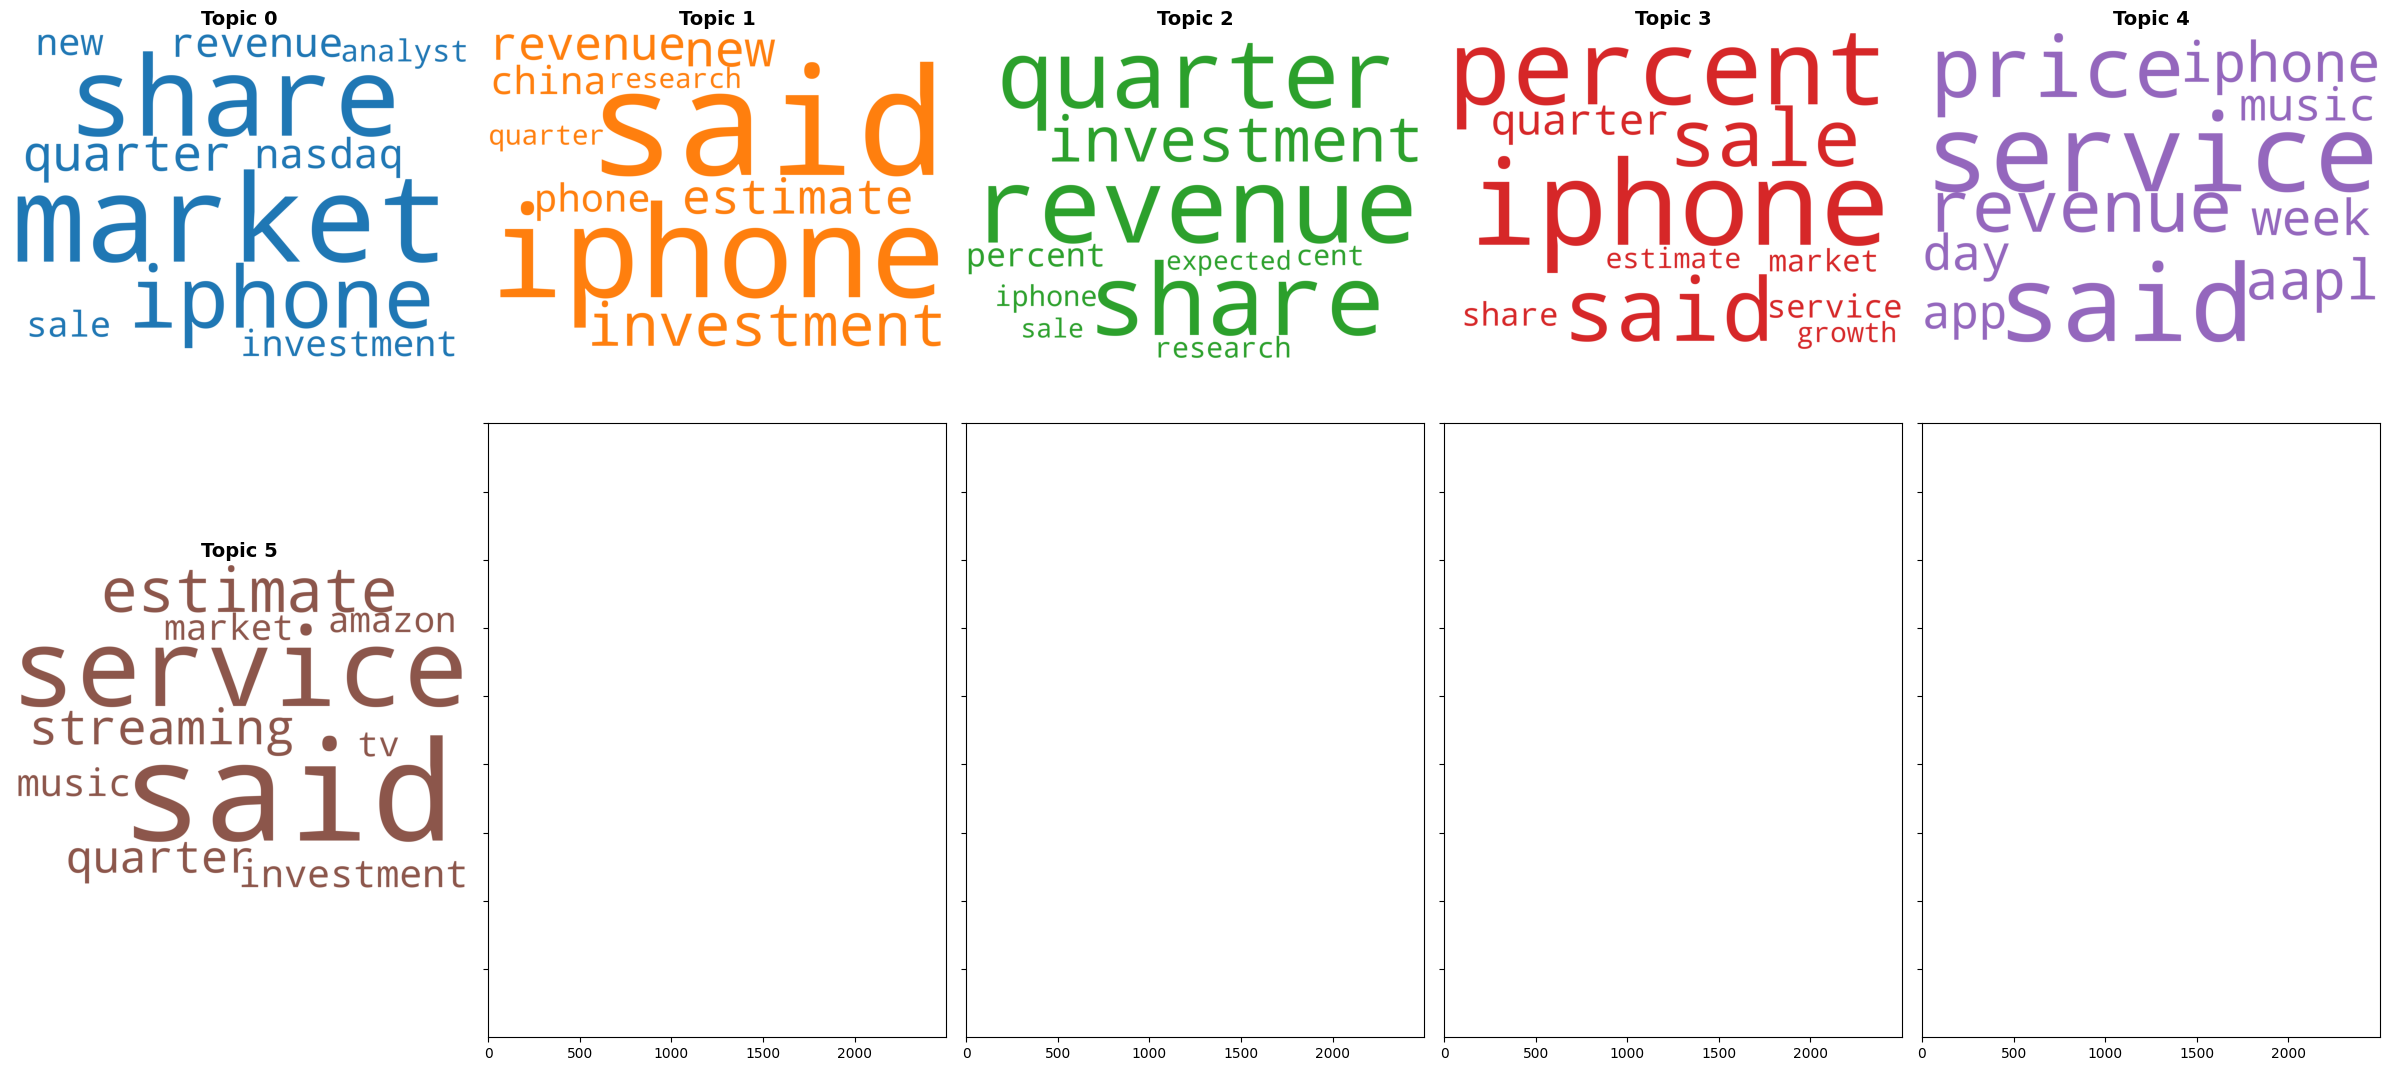

In [53]:
plot_topics(lsa_model)

In [54]:
print_scores(lsa_model, documents)

Coherence: 0.4324630726357111
Diversity: 0.48333333333333334
Interpretability: 0.2090238184405937


#### 1.5.4.7 Iteration 7

* Our `interpretability` increased marginally, but we observe again two topics with the same word `said` → lets remove this word.

In [55]:
documents = remove_from_documents(documents, ["said"])

In [56]:
%%time
lsa_model = create_lsa_model(documents, num_topics=6)

CPU times: user 9.32 s, sys: 7.82 s, total: 17.1 s
Wall time: 2.94 s


In [57]:
print_topics(lsa_model)

Topic 0: [('market', 0.248), ('share', 0.205), ('iphone', 0.202), ('quarter', 0.192), ('nasdaq', 0.183), ('revenue', 0.182), ('investment', 0.149), ('new', 0.147), ('sale', 0.14), ('analyst', 0.139)]
Topic 1: [('iphone', 0.451), ('investment', -0.383), ('research', -0.192), ('sale', 0.18), ('percent', 0.159), ('security', -0.137), ('revenue', 0.128), ('recommendation', -0.126), ('share', 0.122), ('new', 0.112)]
Topic 2: [('revenue', -0.358), ('share', -0.31), ('quarter', -0.287), ('iphone', 0.224), ('new', 0.176), ('cent', -0.174), ('expected', -0.151), ('estimate', -0.15), ('percent', -0.146), ('eps', -0.145)]
Topic 3: [('percent', -0.366), ('iphone', 0.292), ('quarter', 0.245), ('estimate', 0.188), ('sale', 0.185), ('service', 0.185), ('market', -0.178), ('revenue', 0.176), ('share', -0.159), ('growth', 0.146)]
Topic 4: [('service', -0.274), ('iphone', 0.188), ('estimate', 0.177), ('price', 0.174), ('streaming', -0.158), ('music', -0.155), ('app', -0.151), ('amazon', -0.149), ('user'

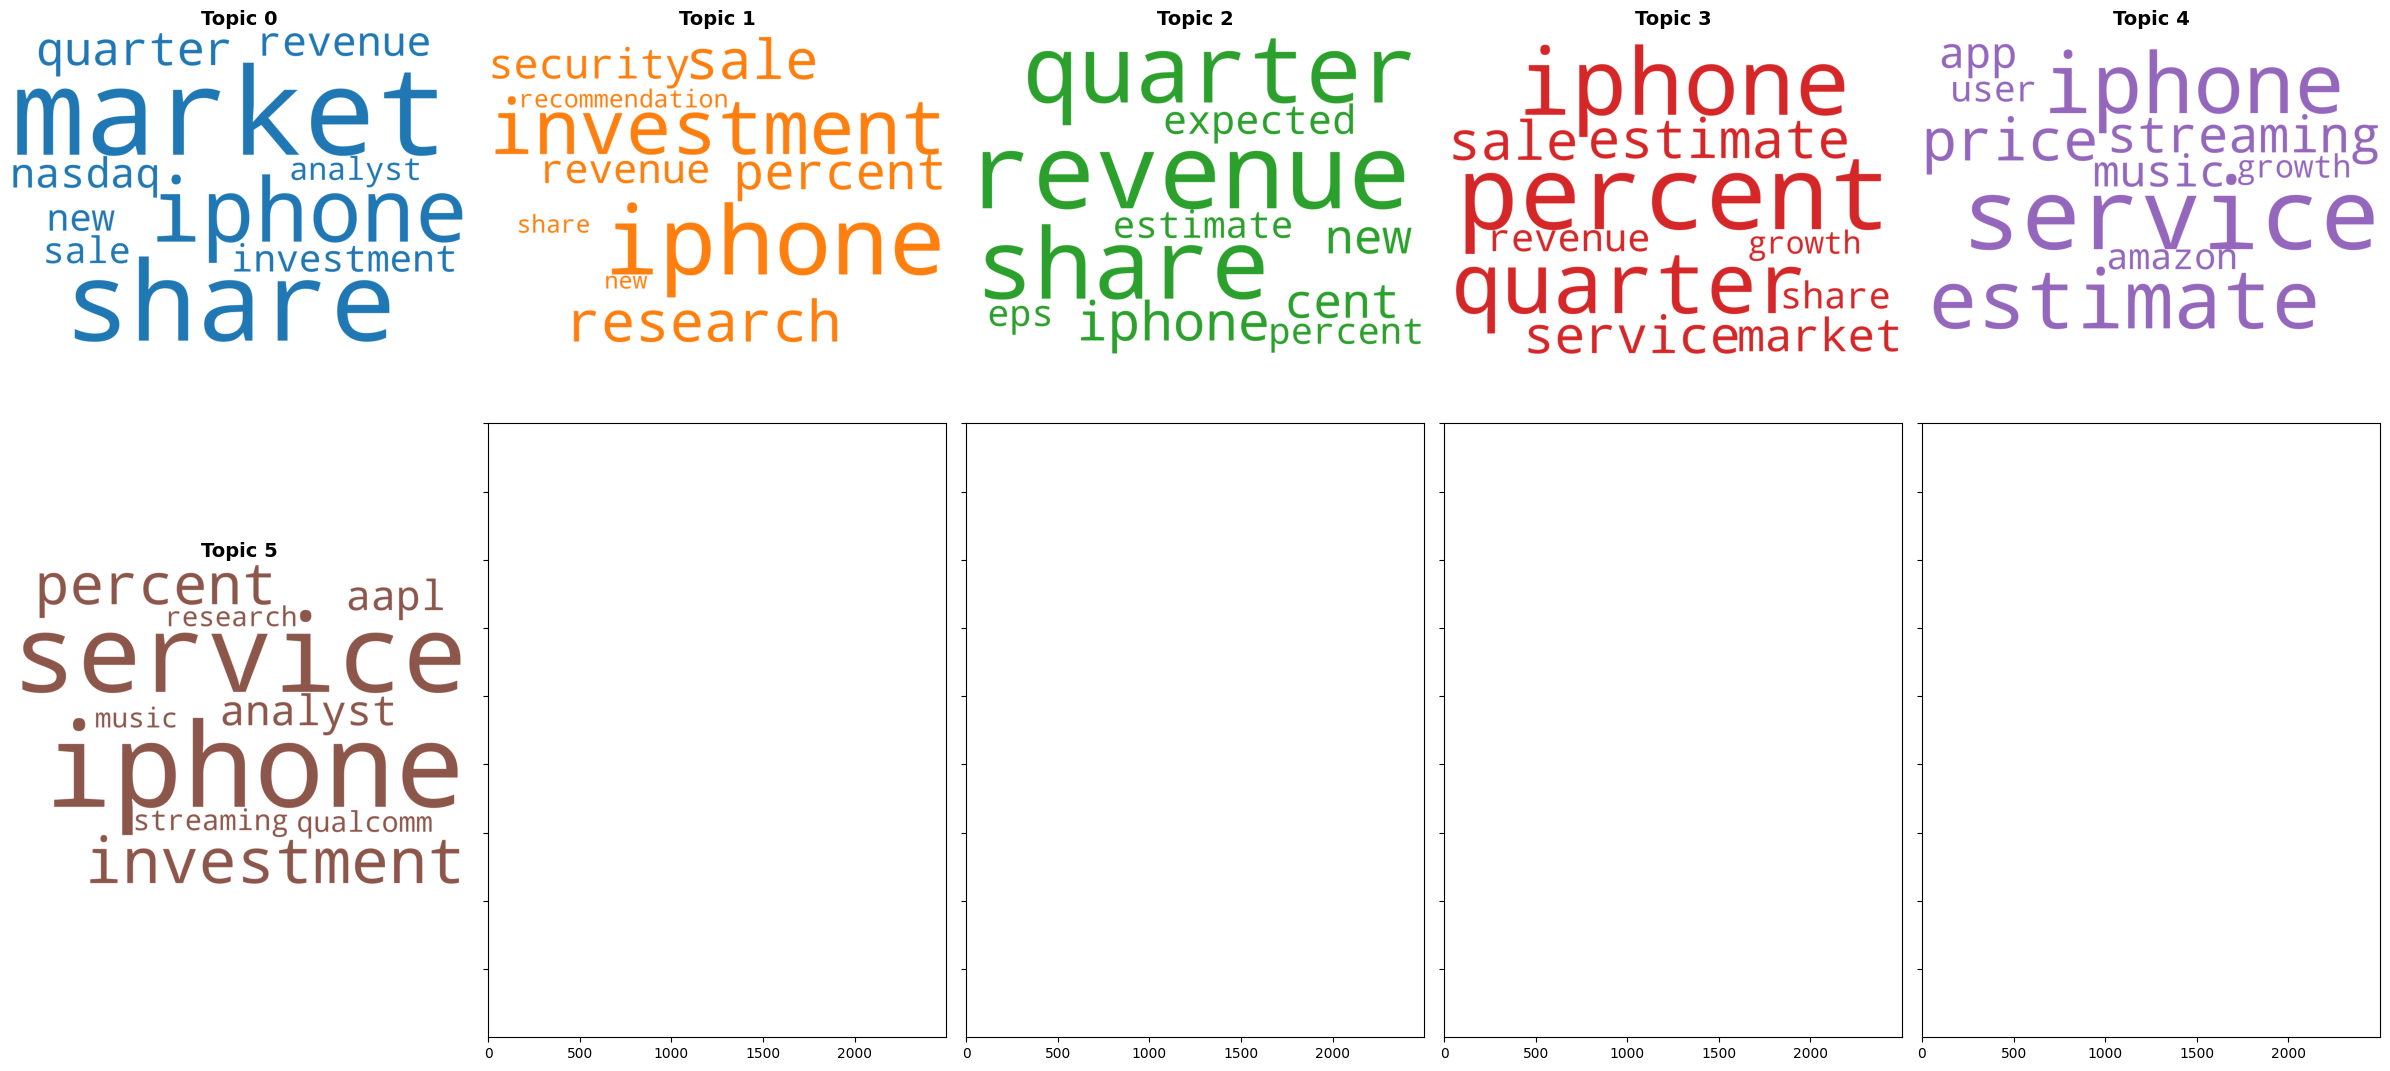

In [58]:
plot_topics(lsa_model)

In [59]:
print_scores(lsa_model, documents)

Coherence: 0.44054003993128027
Diversity: 0.4666666666666667
Interpretability: 0.2055853519679308


#### 1.5.4.8 Iteration 8

* Our `interpretability` decreased marginally, but we observe again two topics with the same word `iphone` → lets remove this word.

In [60]:
documents = remove_from_documents(documents, ["iphone"])

In [61]:
%%time
lsa_model = create_lsa_model(documents, num_topics=6)

CPU times: user 8.47 s, sys: 7.01 s, total: 15.5 s
Wall time: 2.91 s


In [62]:
print_topics(lsa_model)

Topic 0: [('market', 0.255), ('share', 0.21), ('quarter', 0.195), ('nasdaq', 0.187), ('revenue', 0.185), ('investment', 0.156), ('new', 0.146), ('analyst', 0.141), ('sale', 0.138), ('growth', 0.134)]
Topic 1: [('revenue', -0.374), ('share', -0.332), ('quarter', -0.3), ('investment', 0.222), ('percent', -0.21), ('cent', -0.167), ('expected', -0.14), ('eps', -0.132), ('ago', -0.13), ('compared', -0.122)]
Topic 2: [('investment', 0.351), ('new', -0.198), ('estimate', 0.184), ('research', 0.182), ('percent', -0.181), ('china', -0.146), ('rank', 0.126), ('aapl', -0.122), ('phone', -0.121), ('recommendation', 0.12)]
Topic 3: [('service', 0.325), ('percent', -0.321), ('quarter', 0.229), ('sale', 0.221), ('market', -0.21), ('revenue', 0.202), ('share', -0.143), ('music', 0.136), ('million', 0.136), ('week', -0.134)]
Topic 4: [('estimate', -0.23), ('growth', -0.176), ('price', -0.176), ('sale', -0.165), ('percent', 0.163), ('aapl', -0.158), ('quarter', -0.146), ('cent', 0.144), ('share', 0.135)

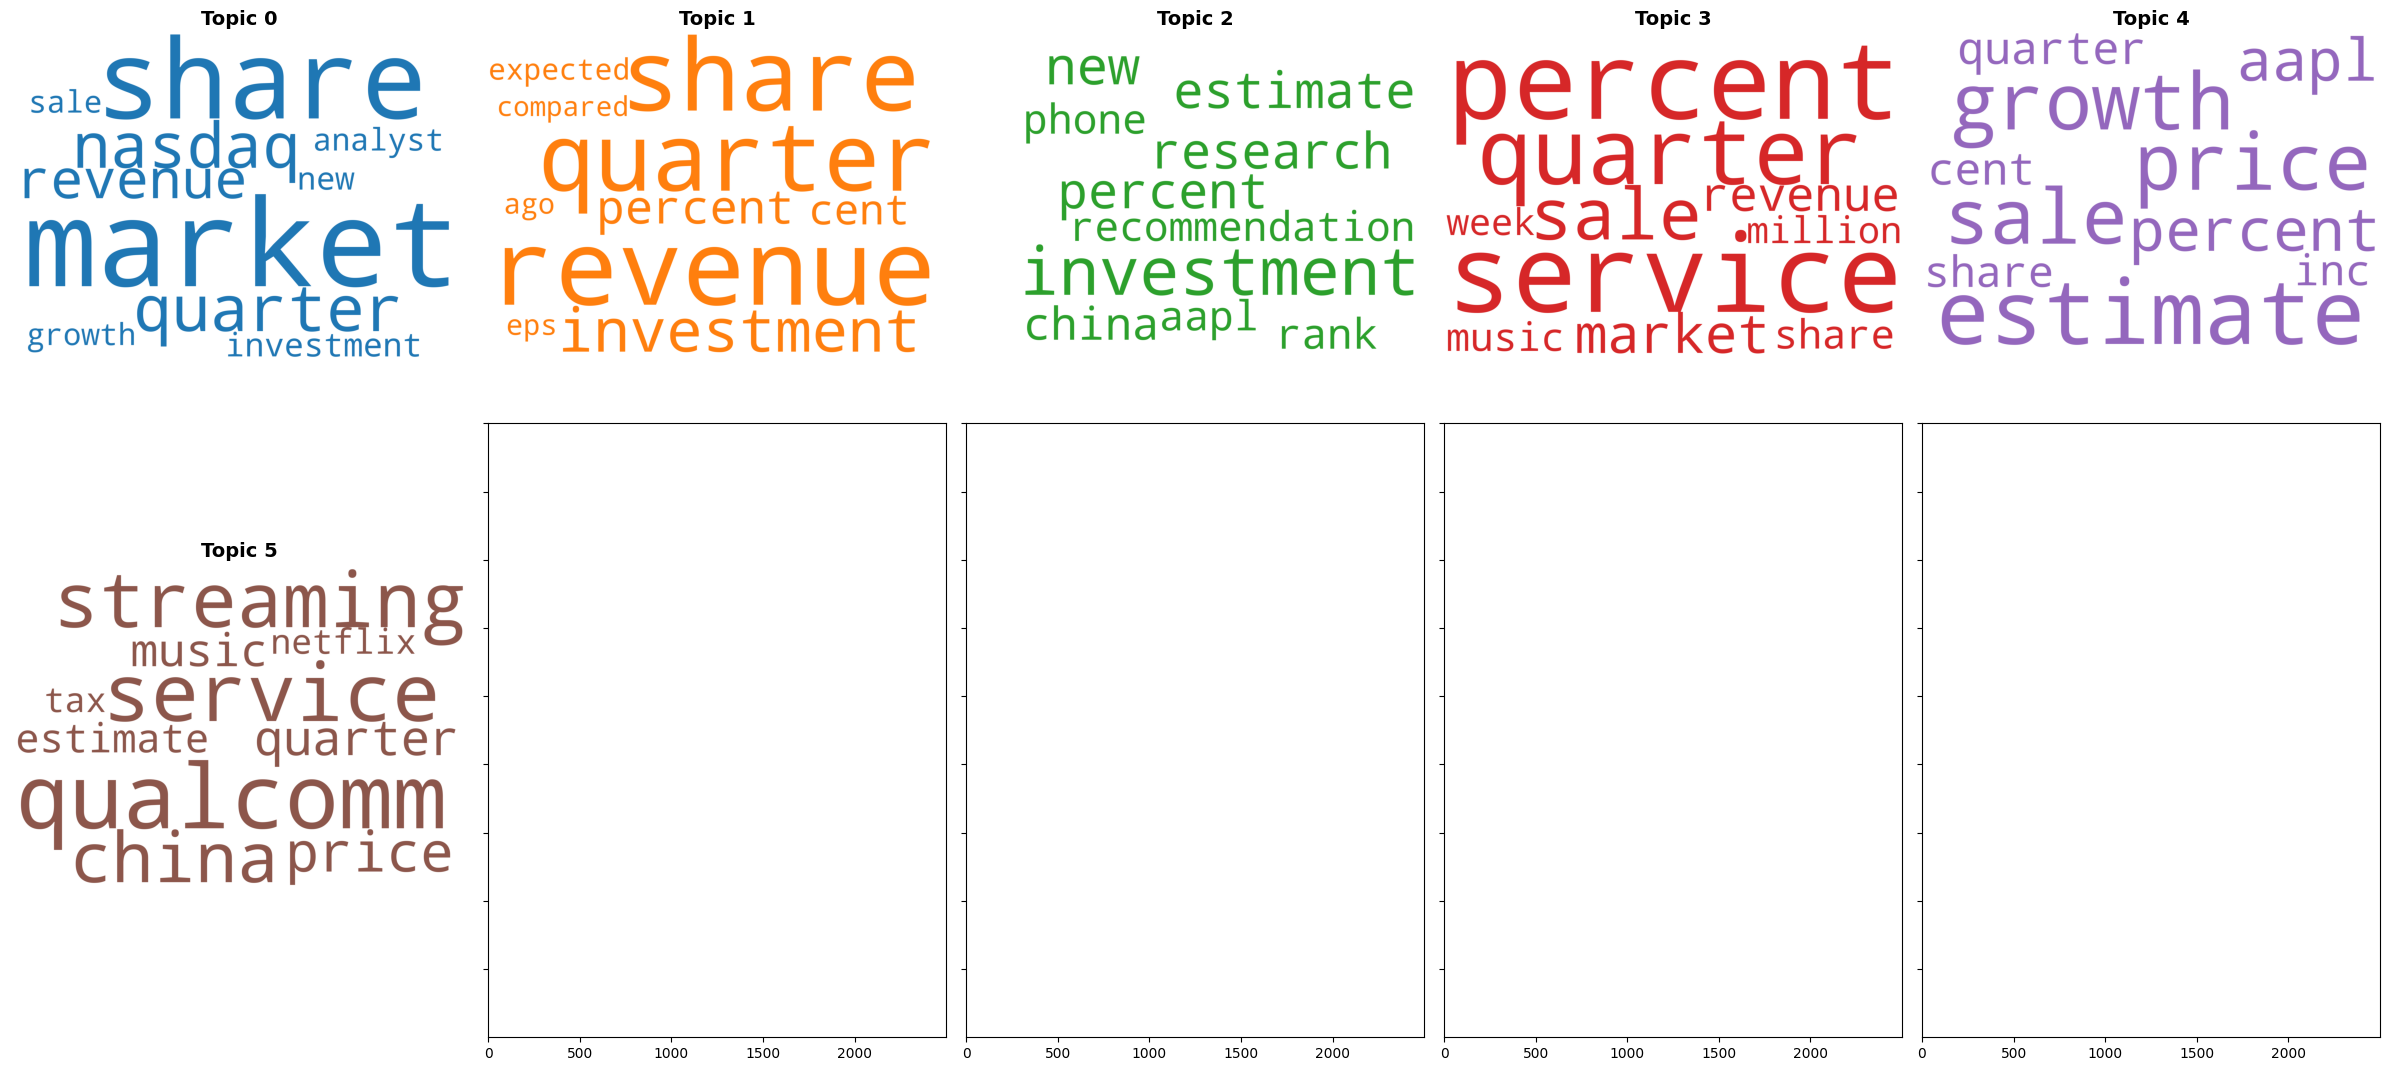

In [63]:
plot_topics(lsa_model)

In [64]:
print_scores(lsa_model, documents)

Coherence: 0.42740193257146286
Diversity: 0.55
Interpretability: 0.2350710629143046


#### 1.5.4.9 Iteration 9

* All our scores improved quite a lot, only `coherence` went down a bit and no duplicate most prominent words in the topic → let's increase number the topics by `1`.

In [65]:
%%time
lsa_model = create_lsa_model(documents, num_topics=7)

CPU times: user 9.23 s, sys: 7.07 s, total: 16.3 s
Wall time: 2.93 s


In [66]:
print_topics(lsa_model)

Topic 0: [('market', 0.255), ('share', 0.21), ('quarter', 0.195), ('nasdaq', 0.187), ('revenue', 0.185), ('investment', 0.156), ('new', 0.146), ('analyst', 0.141), ('sale', 0.138), ('growth', 0.134)]
Topic 1: [('revenue', 0.374), ('share', 0.332), ('quarter', 0.3), ('investment', -0.222), ('percent', 0.21), ('cent', 0.167), ('expected', 0.14), ('eps', 0.132), ('ago', 0.131), ('compared', 0.122)]
Topic 2: [('investment', 0.351), ('new', -0.198), ('estimate', 0.184), ('research', 0.182), ('percent', -0.181), ('china', -0.146), ('rank', 0.126), ('aapl', -0.122), ('phone', -0.121), ('recommendation', 0.12)]
Topic 3: [('service', -0.325), ('percent', 0.321), ('quarter', -0.229), ('sale', -0.221), ('market', 0.21), ('revenue', -0.202), ('share', 0.143), ('music', -0.136), ('million', -0.136), ('week', 0.134)]
Topic 4: [('estimate', 0.23), ('price', 0.176), ('growth', 0.176), ('sale', 0.165), ('percent', -0.163), ('aapl', 0.158), ('quarter', 0.146), ('cent', -0.144), ('share', -0.135), ('inc'

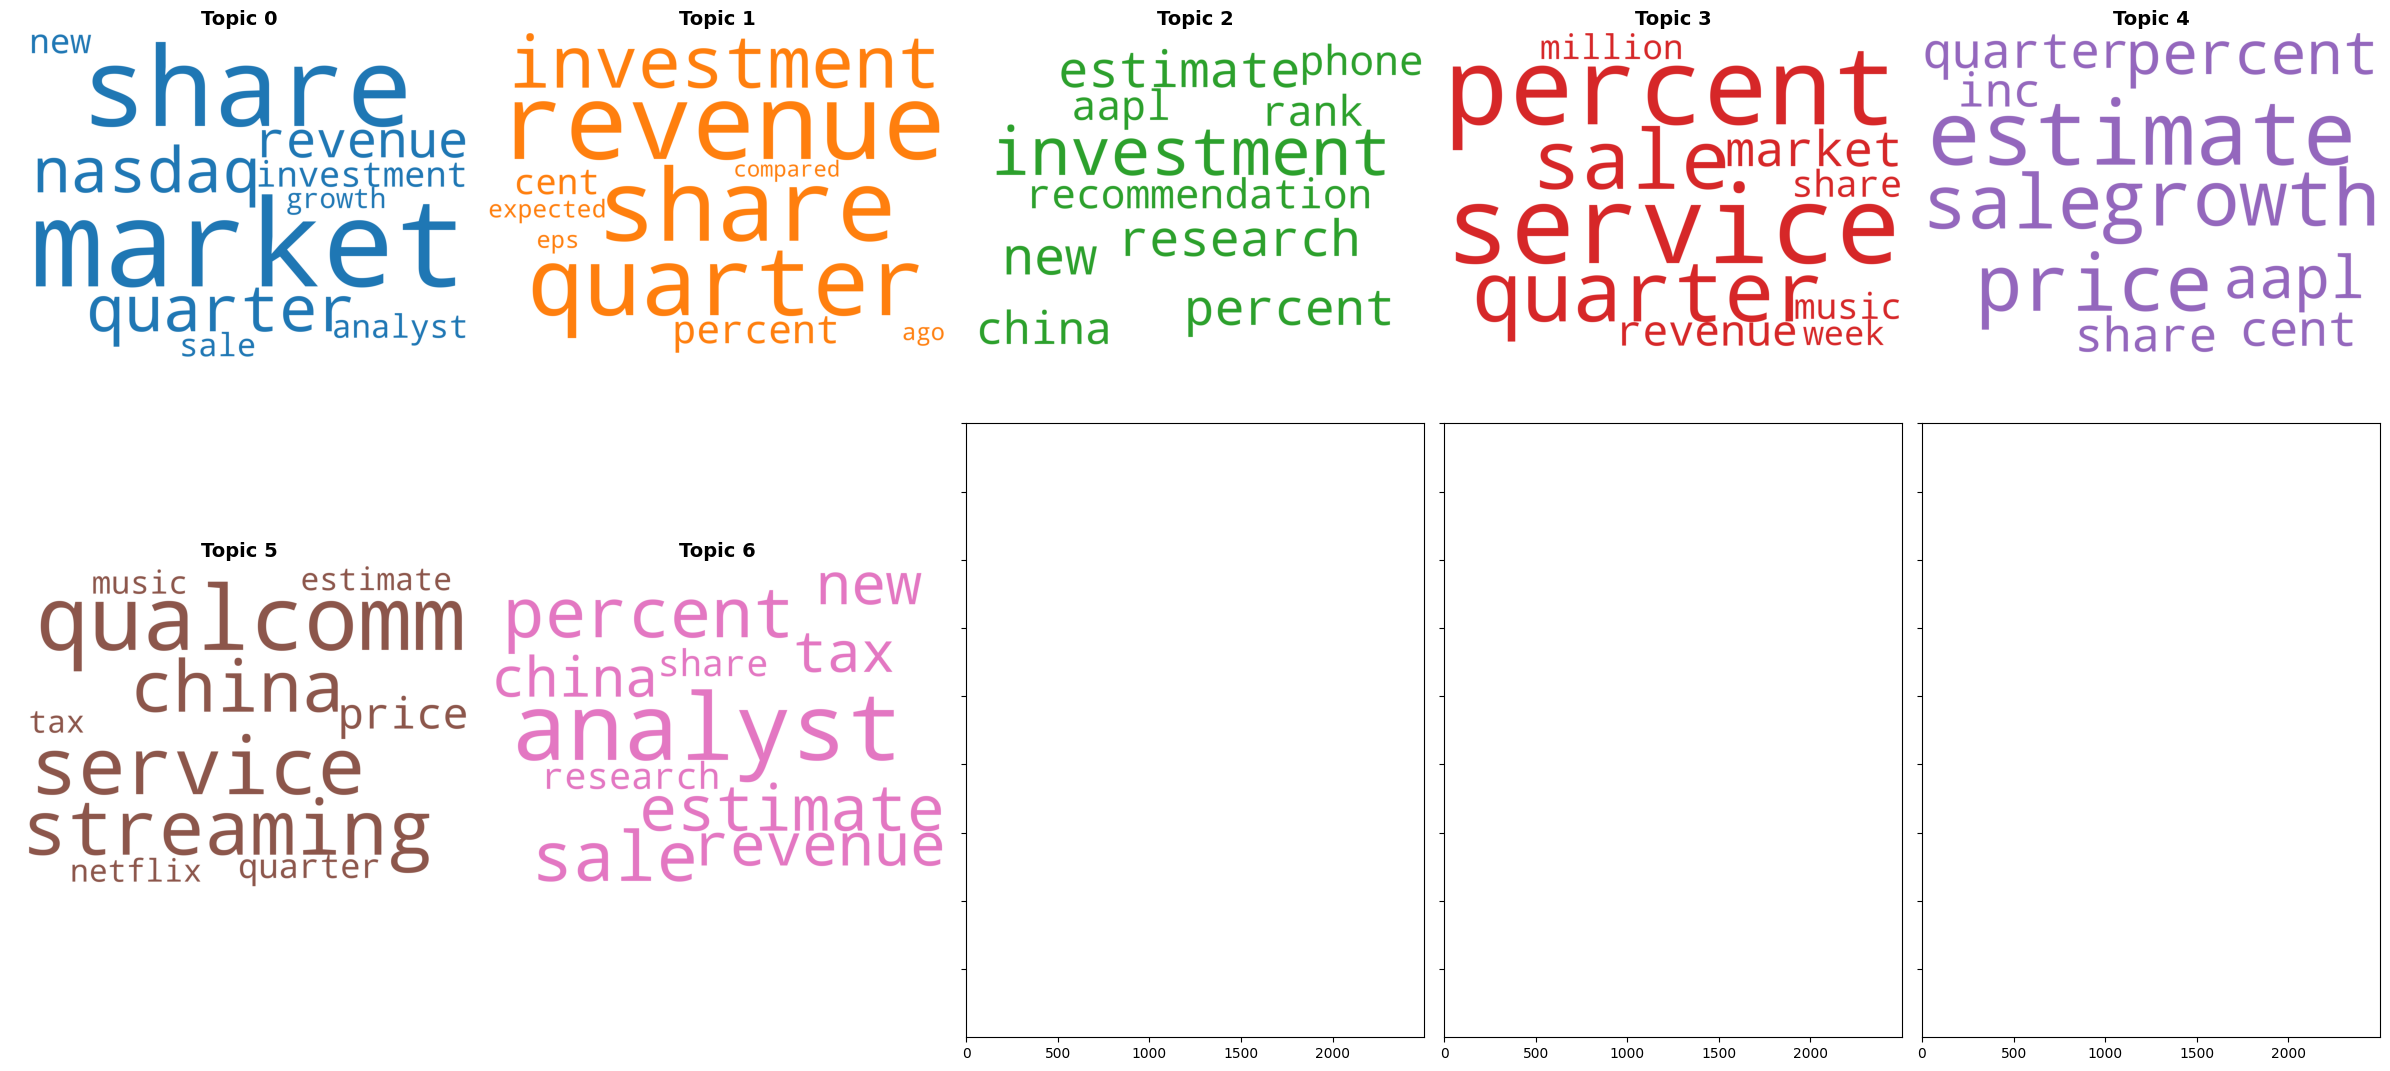

In [67]:
plot_topics(lsa_model)

In [68]:
print_scores(lsa_model, documents)

Coherence: 0.4585176077838623
Diversity: 0.4714285714285714
Interpretability: 0.21615830081239223


#### 1.5.4.10 Iteration 10

* Our `interpretability` went down quite a bit as well as the diversity, still no duplicate most prominent words in the topics, but there are some in second and third place → so lets remove `share` and `quarter`.

In [69]:
documents = remove_from_documents(documents, ["share", "quarter"])

In [70]:
%%time
lsa_model = create_lsa_model(documents, num_topics=7)

CPU times: user 8.74 s, sys: 8.49 s, total: 17.2 s
Wall time: 2.9 s


In [71]:
print_topics(lsa_model)

Topic 0: [('market', 0.266), ('nasdaq', 0.197), ('revenue', 0.183), ('investment', 0.167), ('new', 0.155), ('analyst', 0.148), ('also', 0.141), ('sale', 0.141), ('growth', 0.14), ('service', 0.132)]
Topic 1: [('investment', 0.416), ('percent', -0.26), ('research', 0.216), ('sale', -0.147), ('security', 0.145), ('new', -0.143), ('recommendation', 0.142), ('china', -0.136), ('rank', 0.134), ('buy', 0.122)]
Topic 2: [('revenue', 0.443), ('expected', 0.191), ('cent', 0.189), ('estimate', 0.188), ('percent', 0.179), ('eps', 0.174), ('new', -0.167), ('period', 0.161), ('report', 0.154), ('ago', 0.141)]
Topic 3: [('service', 0.36), ('percent', -0.282), ('revenue', 0.266), ('sale', 0.181), ('market', -0.162), ('music', 0.159), ('week', -0.158), ('streaming', 0.146), ('day', -0.144), ('index', -0.138)]
Topic 4: [('percent', 0.266), ('estimate', -0.243), ('growth', -0.205), ('sale', -0.204), ('price', -0.194), ('inc', 0.162), ('aapl', -0.157), ('market', 0.145), ('investment', 0.144), ('cent', 0

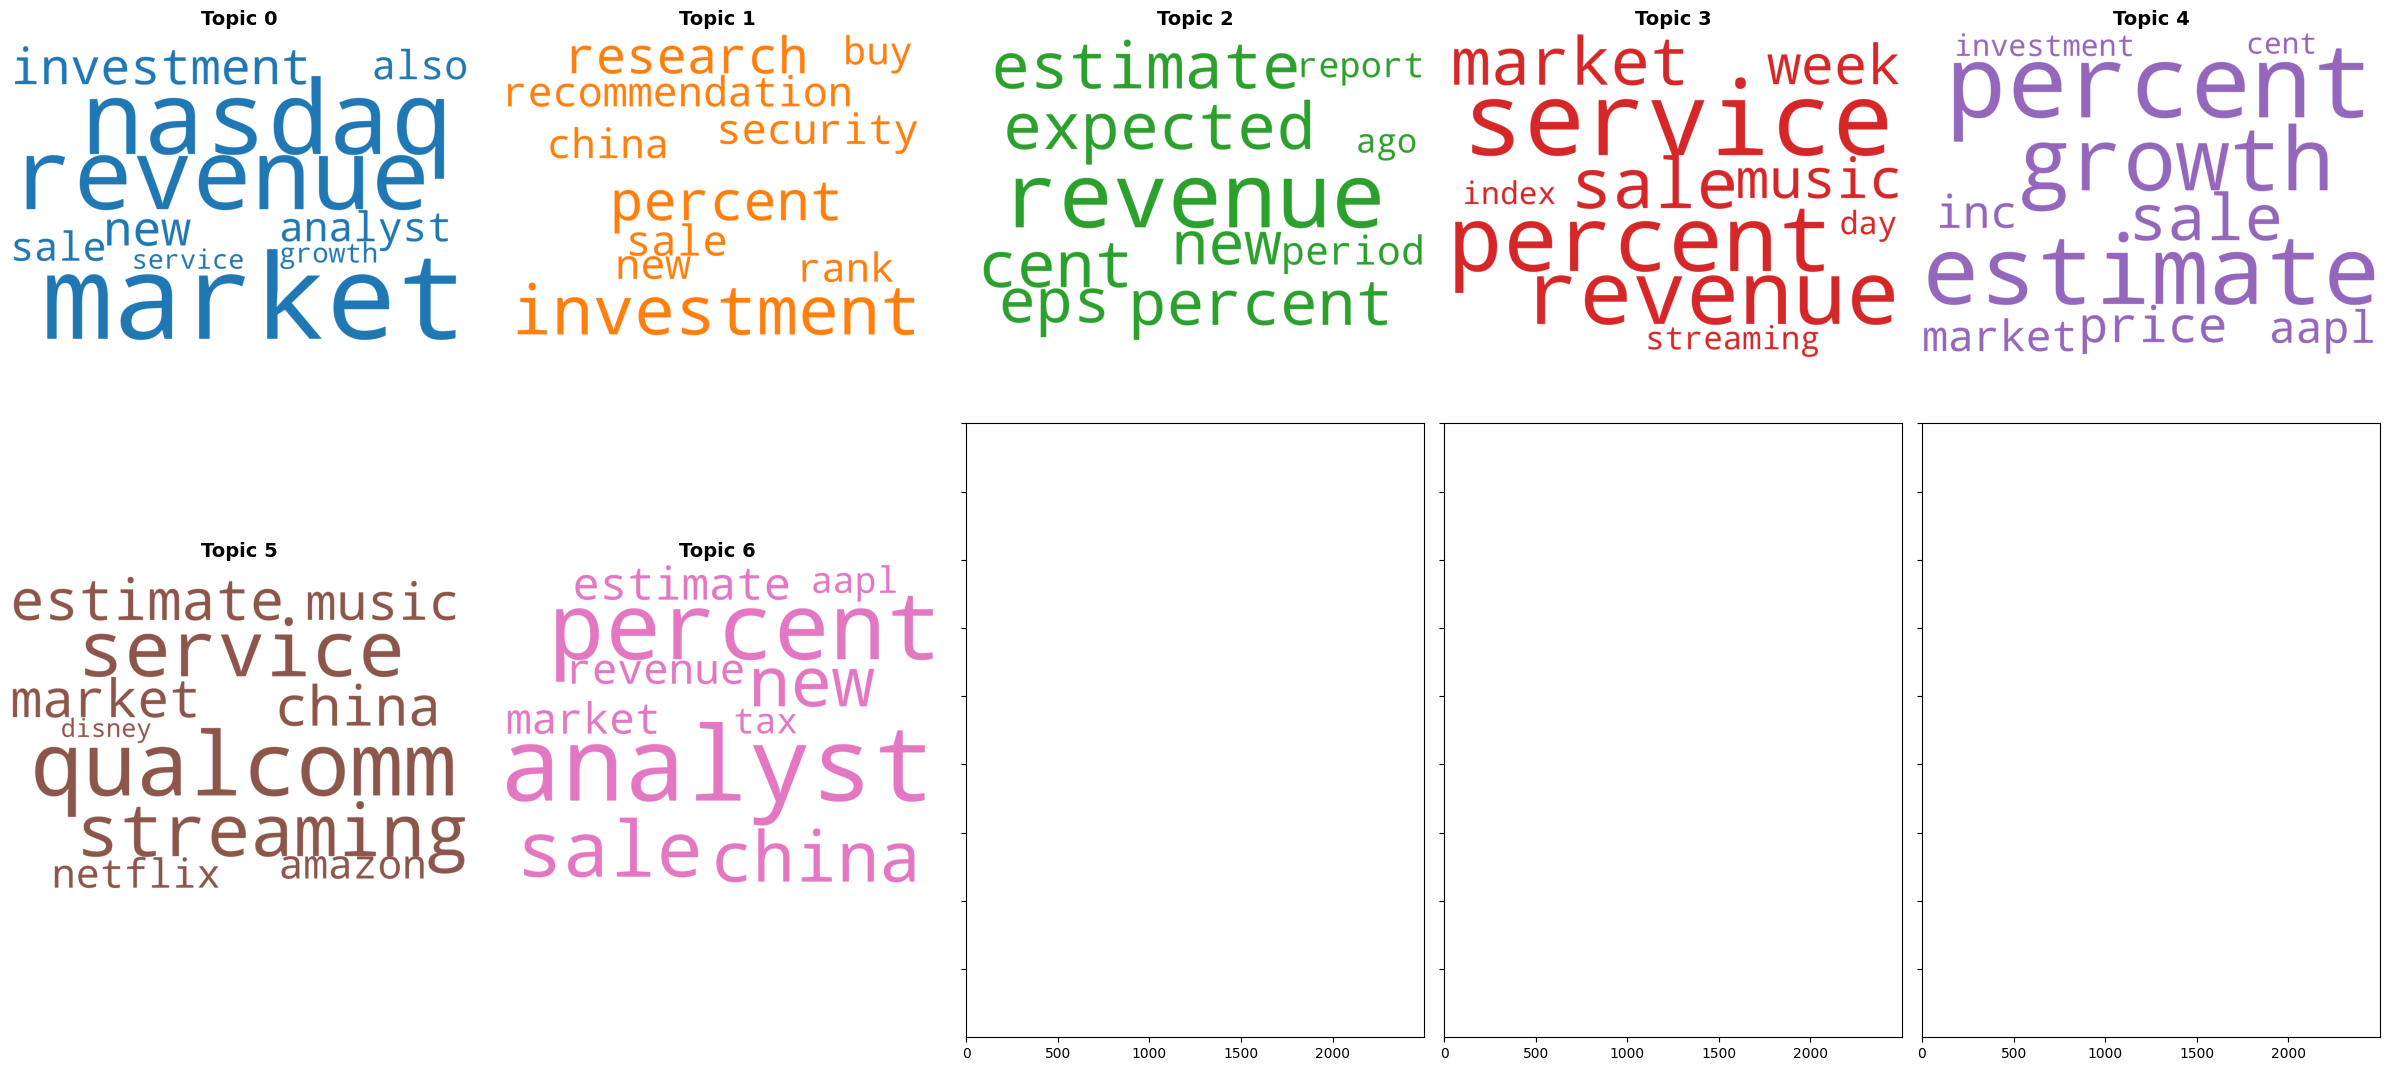

In [72]:
plot_topics(lsa_model)

In [73]:
print_scores(lsa_model, documents)

Coherence: 0.4191396688215619
Diversity: 0.5285714285714286
Interpretability: 0.22154525351996843


**Conclusion**

It's seems quite difficult to get an higher `interpretability` score than `0.25` with LSA, the best iteration has `6` topics and the words: `apple`, `billion`, `earnings`, `year`, `zacks`, `company`, `stock`, `said`, `iphone` removed from the corpus → so let's try LDA, as research shows it is inherently better.

### 1.5.5 LDA modeling

In [74]:
documents = df_us_equities_news["text"].str.split(" ").tolist()

**Find num topics**

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [03:55<00:00, 13.10s/it]


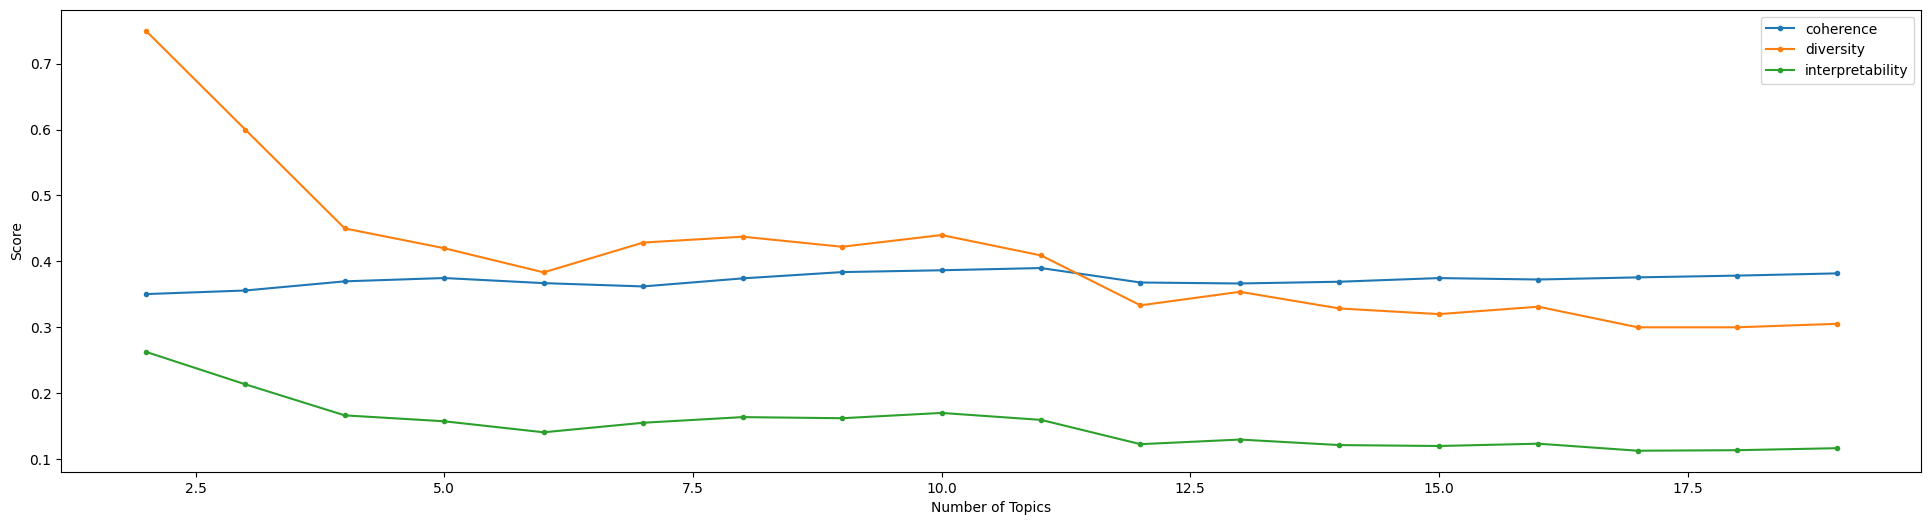

In [75]:
plot_graph(create_lda_model, documents, 2, 20, 1)

#### 1.5.5.1 Iteration 1

In [76]:
%%time
lda_model = create_lda_model(documents, num_topics=5)

CPU times: user 5.83 s, sys: 0 ns, total: 5.83 s
Wall time: 5.83 s


In [77]:
print_topics(lda_model)

Topic 0: [('apple', 0.028), ('year', 0.013), ('iphone', 0.011), ('company', 0.01), ('china', 0.009), ('quarter', 0.009), ('share', 0.008), ('said', 0.008), ('sale', 0.008), ('analyst', 0.008)]
Topic 1: [('stock', 0.017), ('zacks', 0.013), ('apple', 0.013), ('company', 0.012), ('year', 0.011), ('investment', 0.009), ('nasdaq', 0.008), ('market', 0.008), ('share', 0.006), ('earnings', 0.006)]
Topic 2: [('apple', 0.03), ('nasdaq', 0.009), ('company', 0.009), ('stock', 0.009), ('year', 0.008), ('zacks', 0.008), ('service', 0.007), ('billion', 0.006), ('market', 0.006), ('investment', 0.006)]
Topic 3: [('apple', 0.036), ('year', 0.013), ('stock', 0.011), ('company', 0.011), ('iphone', 0.011), ('earnings', 0.009), ('revenue', 0.008), ('billion', 0.007), ('quarter', 0.007), ('share', 0.007)]
Topic 4: [('apple', 0.026), ('company', 0.01), ('said', 0.01), ('iphone', 0.008), ('qualcomm', 0.007), ('market', 0.007), ('nasdaq', 0.006), ('new', 0.006), ('china', 0.006), ('year', 0.005)]


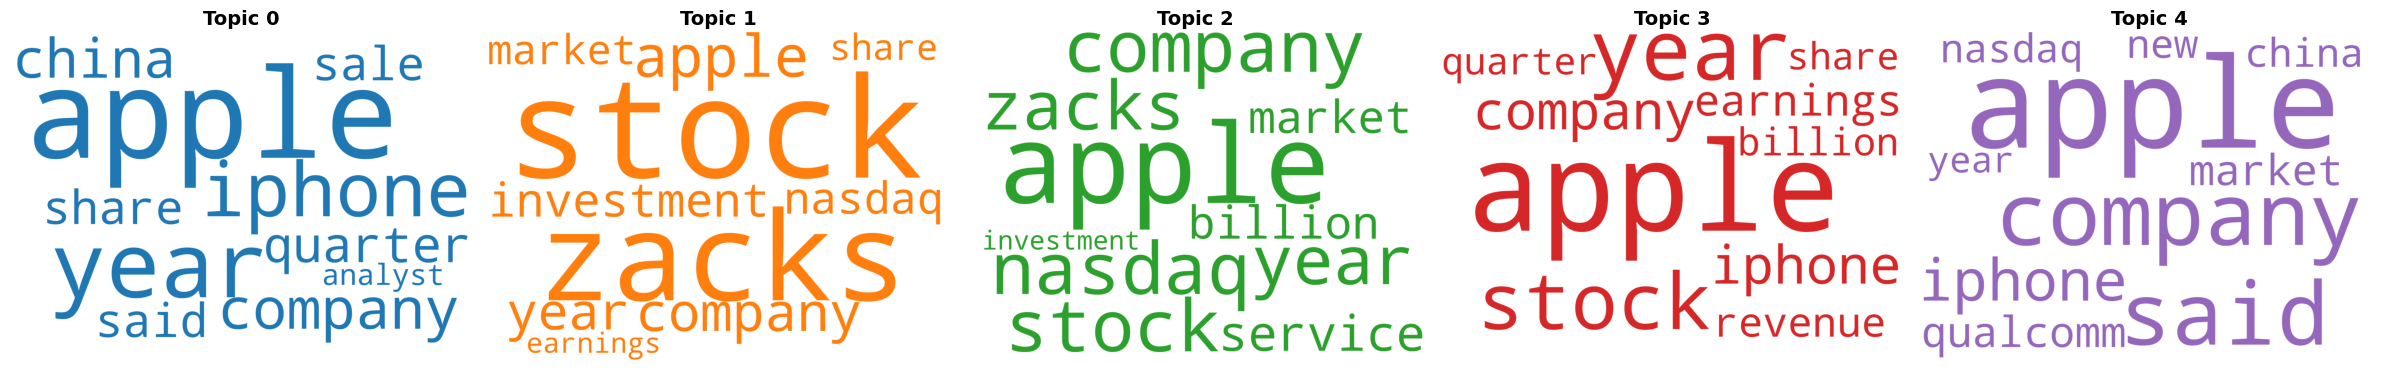

In [78]:
plot_topics(lda_model)

In [79]:
print_scores(lda_model, documents)

Coherence: 0.37474988875917764
Diversity: 0.42
Interpretability: 0.1573949532788546


#### 1.5.5.2 Iteration 2

* We observe that `apple`, `year`, `stock`, `company`, `said` all occur in the top-3 of each of the topics albeit in different positions → we remove these words.
* We observe that `zacks` also ranks high → we remove this word, as it is the name of one of the publishers and therefore unimportant.

In [80]:
documents = remove_from_documents(documents, ["apple", "year", "stock", "company", "said", "zacks"])

In [81]:
%%time
lda_model = create_lda_model(documents, num_topics=5)

CPU times: user 5.52 s, sys: 0 ns, total: 5.52 s
Wall time: 5.51 s


In [82]:
print_topics(lda_model)

Topic 0: [('market', 0.009), ('earnings', 0.009), ('investment', 0.009), ('analyst', 0.007), ('nasdaq', 0.007), ('service', 0.007), ('quarter', 0.006), ('billion', 0.006), ('share', 0.006), ('growth', 0.006)]
Topic 1: [('nasdaq', 0.006), ('tax', 0.005), ('billion', 0.005), ('inc', 0.005), ('court', 0.005), ('percent', 0.005), ('reuters', 0.005), ('would', 0.004), ('aapl', 0.004), ('new', 0.004)]
Topic 2: [('qualcomm', 0.011), ('nasdaq', 0.011), ('market', 0.007), ('nyse', 0.006), ('also', 0.005), ('earnings', 0.004), ('chip', 0.004), ('intel', 0.004), ('day', 0.004), ('aapl', 0.004)]
Topic 3: [('iphone', 0.013), ('sale', 0.008), ('new', 0.008), ('billion', 0.008), ('share', 0.008), ('china', 0.008), ('revenue', 0.008), ('service', 0.008), ('quarter', 0.007), ('market', 0.007)]
Topic 4: [('iphone', 0.011), ('nasdaq', 0.009), ('new', 0.007), ('market', 0.006), ('inc', 0.006), ('technology', 0.005), ('share', 0.005), ('aapl', 0.005), ('billion', 0.005), ('could', 0.005)]


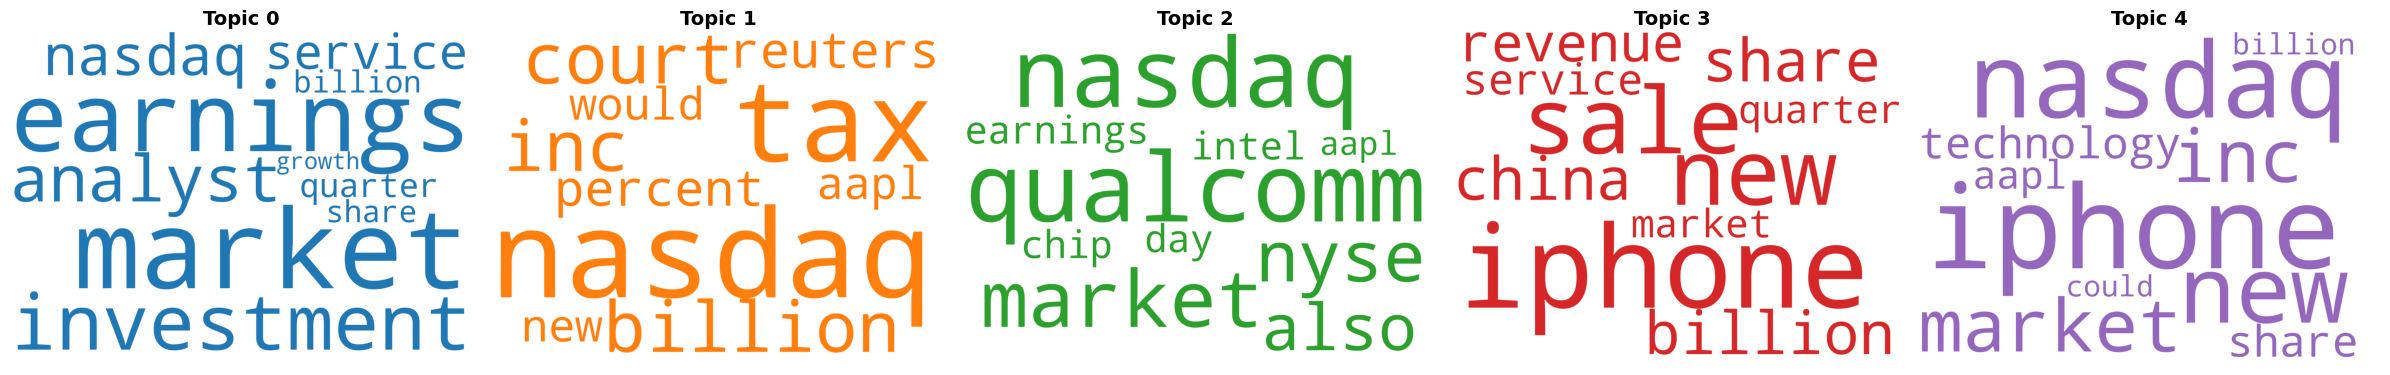

In [83]:
plot_topics(lda_model)

In [84]:
print_scores(lda_model, documents)

Coherence: 0.36267434644660135
Diversity: 0.6
Interpretability: 0.2176046078679608


#### 1.5.5.3 Iteration 3

* We observe that two topics contain the same words (`iphone` and `nasdaq`) → so we remove these words.
* We also observe that our `coherence` score is a bit low → so we increase the number of topics by `5`.

In [85]:
documents = remove_from_documents(documents, ["iphone", "nasdaq"])

In [86]:
%%time
lda_model = create_lda_model(documents, num_topics=10)

CPU times: user 6.18 s, sys: 1.42 s, total: 7.6 s
Wall time: 5.88 s


In [87]:
print_topics(lda_model)

Topic 0: [('billion', 0.013), ('earnings', 0.012), ('revenue', 0.012), ('quarter', 0.011), ('share', 0.011), ('analyst', 0.009), ('sale', 0.008), ('estimate', 0.008), ('market', 0.008), ('price', 0.007)]
Topic 1: [('new', 0.009), ('market', 0.006), ('china', 0.005), ('also', 0.005), ('user', 0.005), ('percent', 0.005), ('data', 0.004), ('share', 0.004), ('inc', 0.004), ('would', 0.004)]
Topic 2: [('sale', 0.011), ('market', 0.009), ('china', 0.008), ('nyse', 0.008), ('billion', 0.007), ('quarter', 0.006), ('revenue', 0.006), ('qualcomm', 0.006), ('chip', 0.006), ('share', 0.006)]
Topic 3: [('aapl', 0.008), ('market', 0.006), ('earnings', 0.005), ('china', 0.005), ('day', 0.004), ('would', 0.004), ('price', 0.004), ('trade', 0.004), ('share', 0.004), ('time', 0.004)]
Topic 4: [('nyse', 0.009), ('share', 0.008), ('dow', 0.008), ('billion', 0.006), ('market', 0.006), ('earnings', 0.005), ('quarter', 0.005), ('report', 0.005), ('qualcomm', 0.005), ('inc', 0.005)]
Topic 5: [('app', 0.01), (

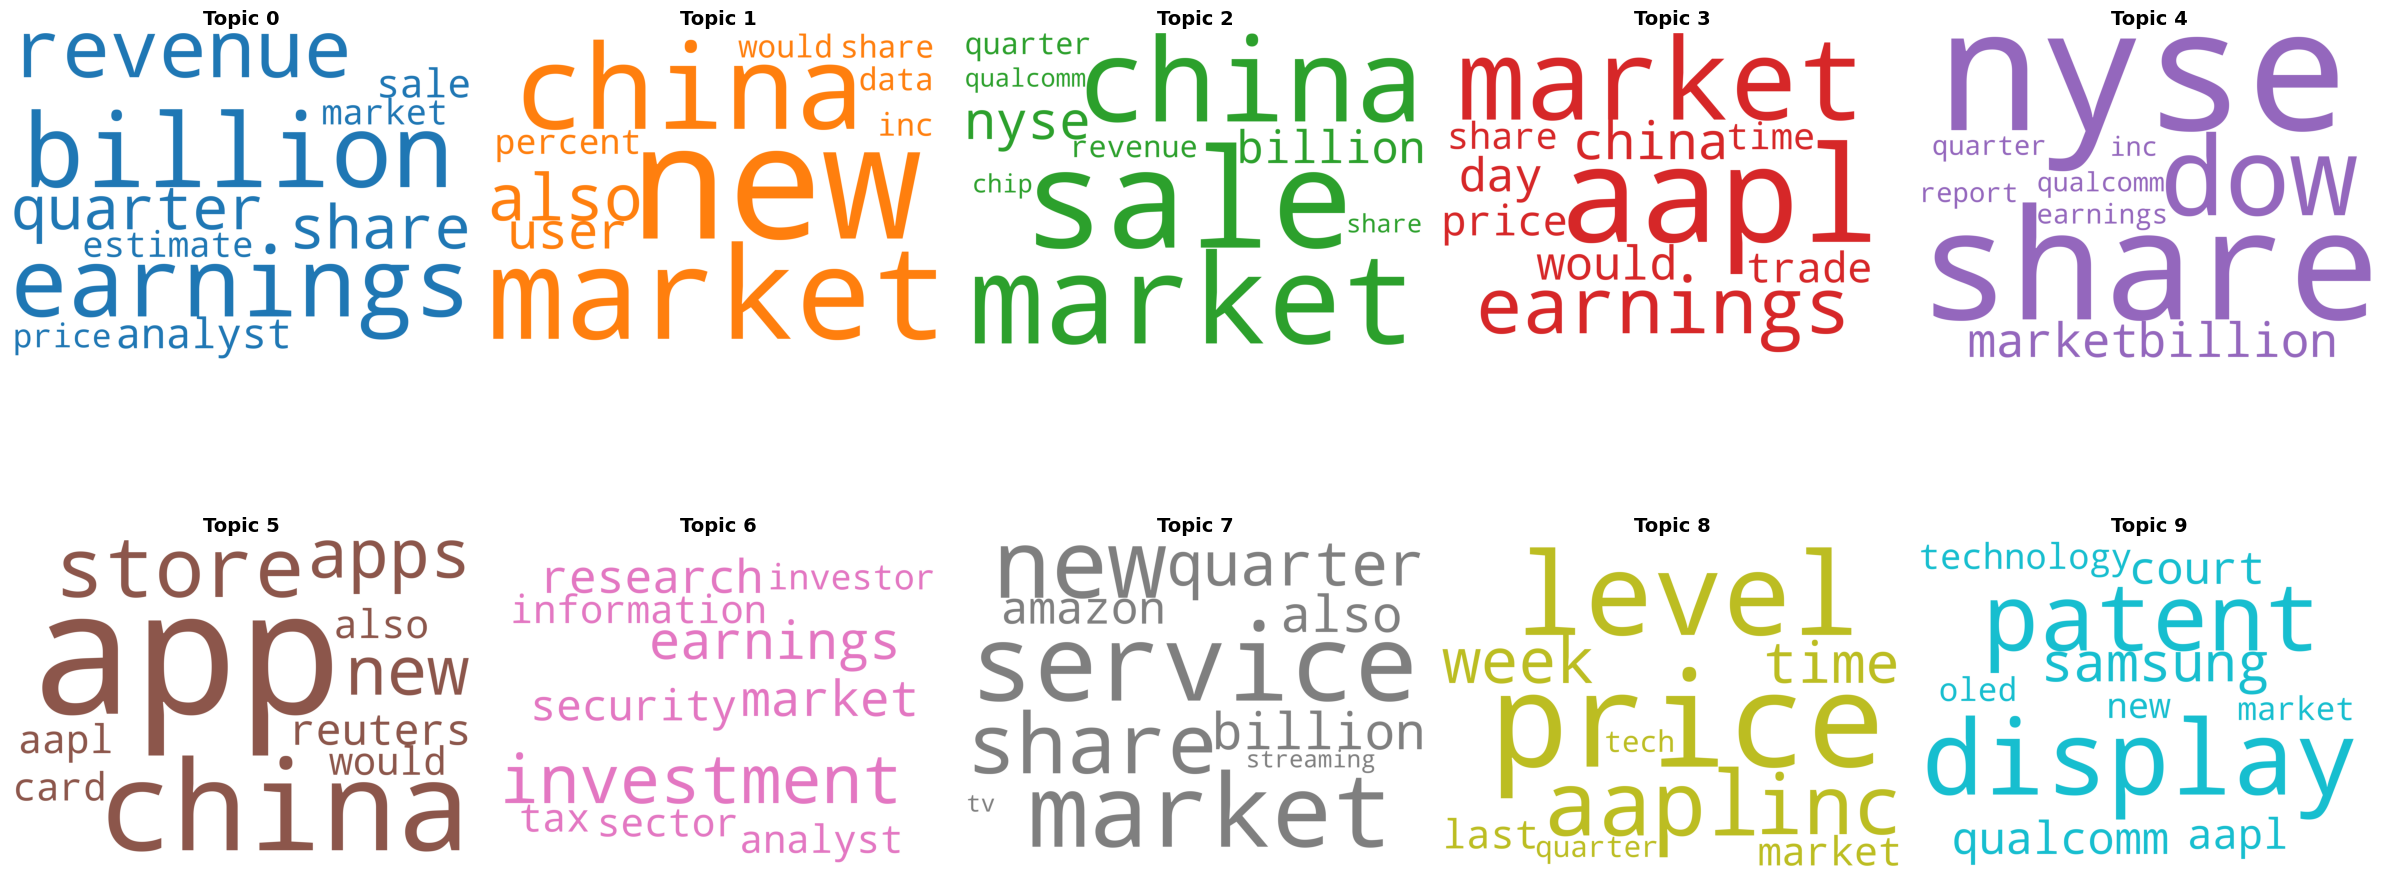

In [88]:
plot_topics(lda_model)

In [89]:
print_scores(lda_model, documents)

Coherence: 0.3981133294050432
Diversity: 0.53
Interpretability: 0.2110000645846729


#### 1.5.5.4 Iteration 4

* We observe that `market` and `earnings` are often the second most prominent words in the topics → so we remove these words.
* We still observe that our `coherence` score is a bit low → so we increase the number of topics by `5`.

In [90]:
documents = remove_from_documents(documents, ["market", "earnings"])

In [91]:
%%time
lda_model = create_lda_model(documents, num_topics=15)

CPU times: user 14.3 s, sys: 34.7 s, total: 49.1 s
Wall time: 8.15 s


In [92]:
print_topics(lda_model)

Topic 0: [('investment', 0.019), ('growth', 0.008), ('research', 0.008), ('estimate', 0.007), ('analyst', 0.006), ('report', 0.006), ('security', 0.006), ('rank', 0.006), ('sector', 0.006), ('current', 0.005)]
Topic 1: [('billion', 0.013), ('quarter', 0.011), ('sale', 0.01), ('share', 0.01), ('revenue', 0.01), ('analyst', 0.009), ('new', 0.008), ('service', 0.006), ('growth', 0.006), ('also', 0.006)]
Topic 2: [('share', 0.007), ('billion', 0.006), ('china', 0.005), ('aapl', 0.005), ('new', 0.005), ('nyse', 0.005), ('sale', 0.005), ('time', 0.004), ('store', 0.004), ('tax', 0.004)]
Topic 3: [('analyst', 0.008), ('user', 0.008), ('service', 0.007), ('investment', 0.007), ('research', 0.007), ('security', 0.006), ('facebook', 0.006), ('blog', 0.006), ('buy', 0.006), ('app', 0.006)]
Topic 4: [('aapl', 0.007), ('new', 0.006), ('inc', 0.006), ('share', 0.005), ('would', 0.005), ('report', 0.005), ('last', 0.004), ('fitbit', 0.004), ('also', 0.004), ('see', 0.003)]
Topic 5: [('service', 0.007

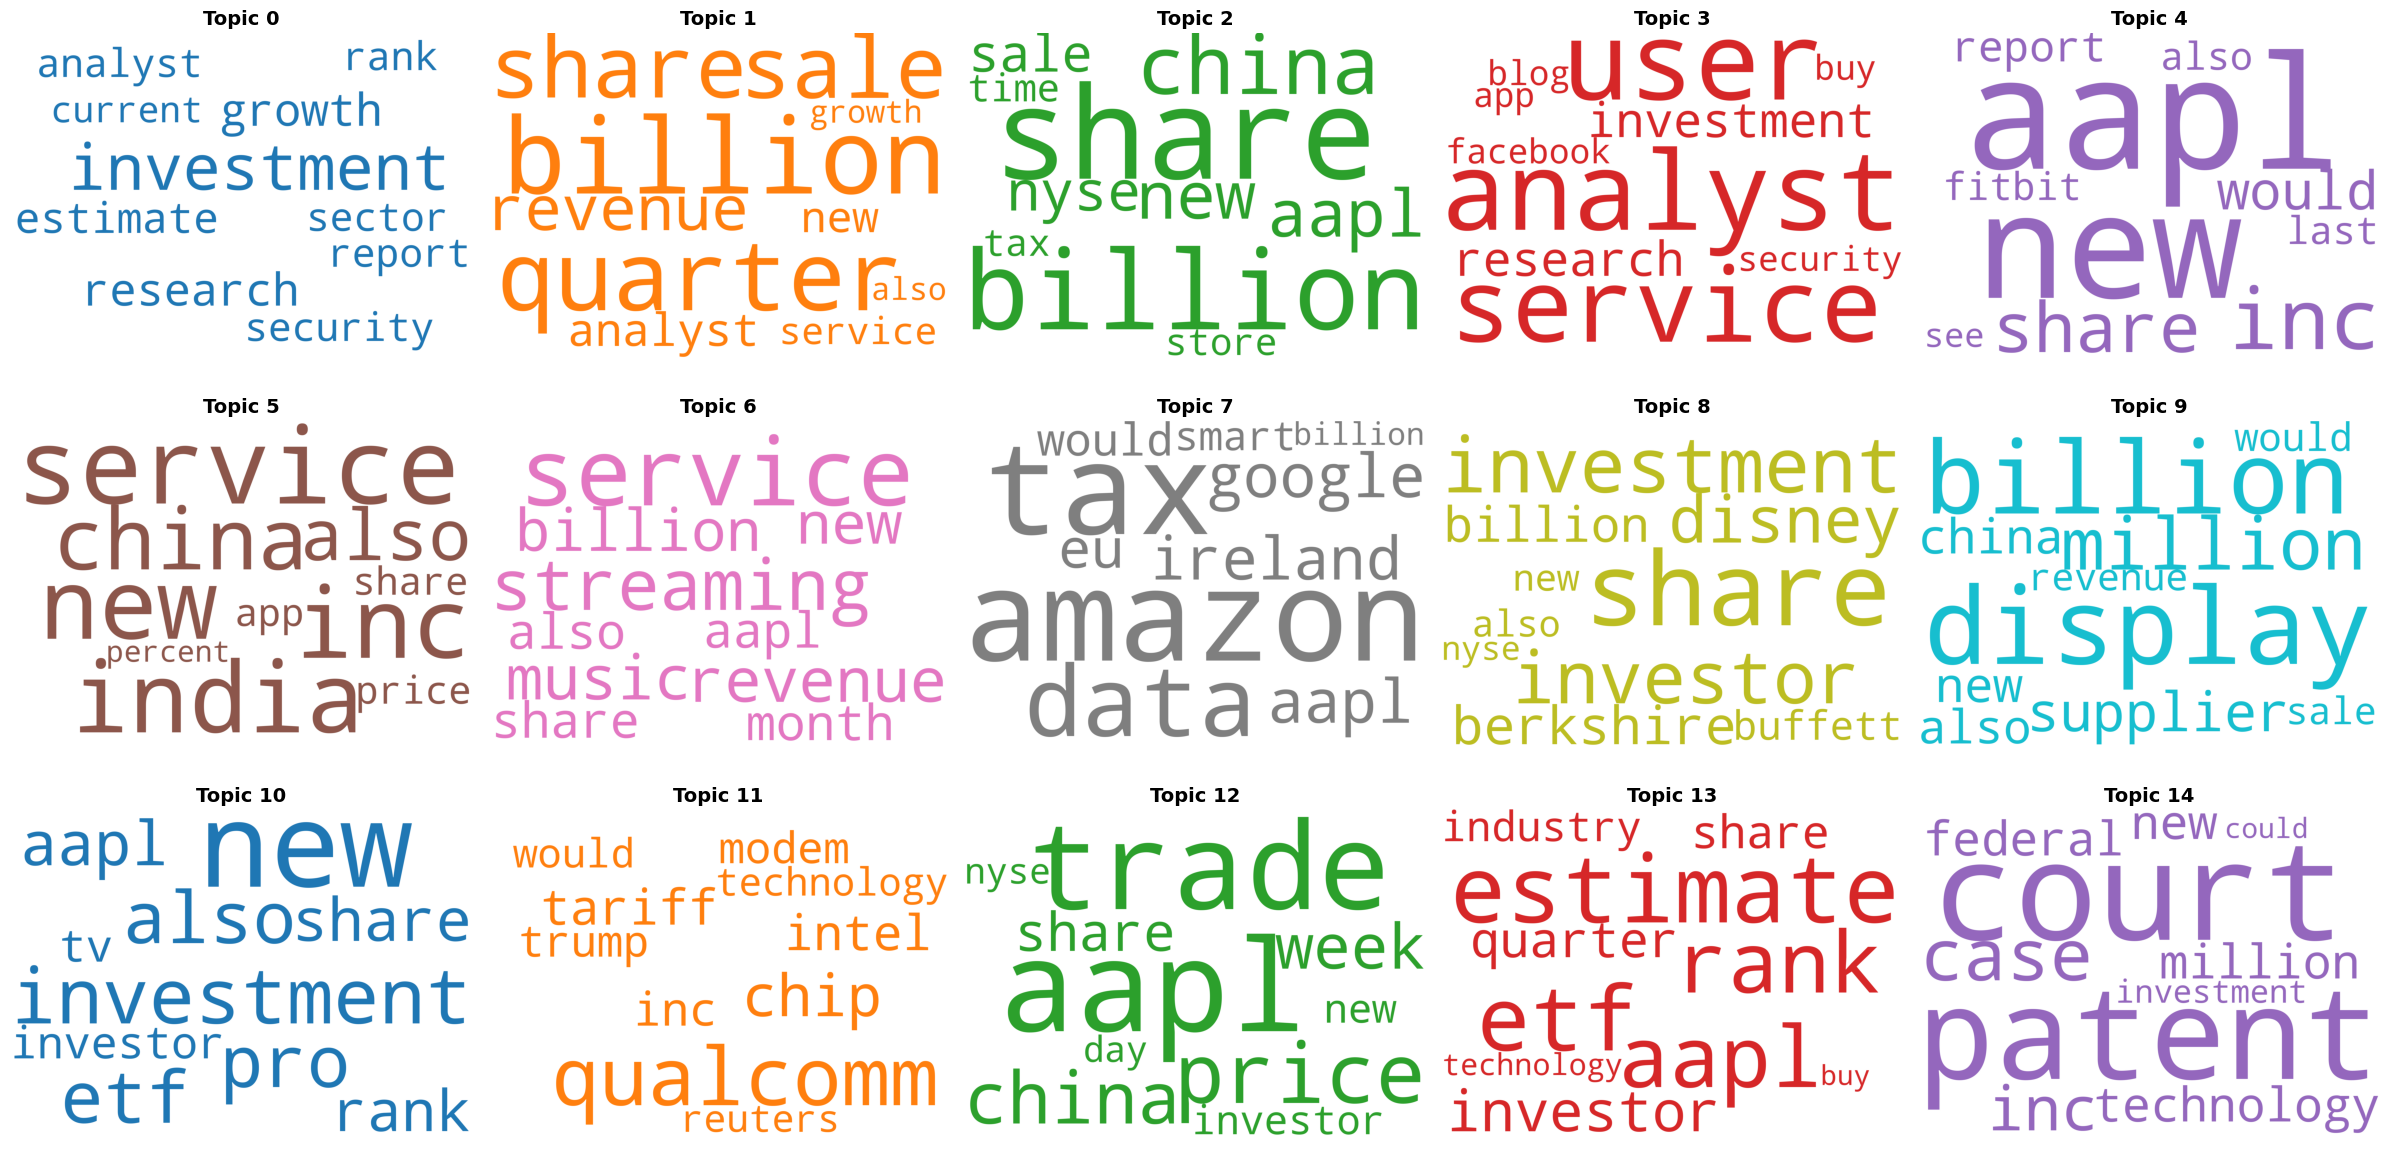

In [93]:
plot_topics(lda_model)

In [94]:
print_scores(lda_model, documents)

Coherence: 0.3799004342514251
Diversity: 0.4866666666666667
Interpretability: 0.18488487800236023


#### 1.5.5.5 Iteration 5

* Our performance seems to get worse → so let's decrease the number of topics by `3`.

In [95]:
%%time
lda_model = create_lda_model(documents, num_topics=12)

CPU times: user 7.12 s, sys: 4.77 s, total: 11.9 s
Wall time: 6.3 s


In [96]:
print_topics(lda_model)

Topic 0: [('investment', 0.015), ('growth', 0.007), ('estimate', 0.007), ('price', 0.006), ('research', 0.006), ('aapl', 0.006), ('rank', 0.005), ('investor', 0.005), ('may', 0.005), ('report', 0.005)]
Topic 1: [('billion', 0.012), ('quarter', 0.011), ('share', 0.01), ('sale', 0.01), ('revenue', 0.009), ('analyst', 0.009), ('new', 0.008), ('growth', 0.006), ('service', 0.006), ('price', 0.006)]
Topic 2: [('share', 0.007), ('aapl', 0.006), ('china', 0.006), ('nyse', 0.006), ('billion', 0.006), ('new', 0.005), ('sale', 0.005), ('trade', 0.005), ('time', 0.005), ('tax', 0.004)]
Topic 3: [('user', 0.007), ('analyst', 0.007), ('investment', 0.007), ('service', 0.007), ('facebook', 0.006), ('research', 0.006), ('app', 0.006), ('security', 0.006), ('also', 0.005), ('google', 0.005)]
Topic 4: [('aapl', 0.008), ('new', 0.006), ('inc', 0.005), ('share', 0.005), ('would', 0.005), ('last', 0.004), ('report', 0.004), ('also', 0.004), ('see', 0.004), ('time', 0.004)]
Topic 5: [('service', 0.007), ('

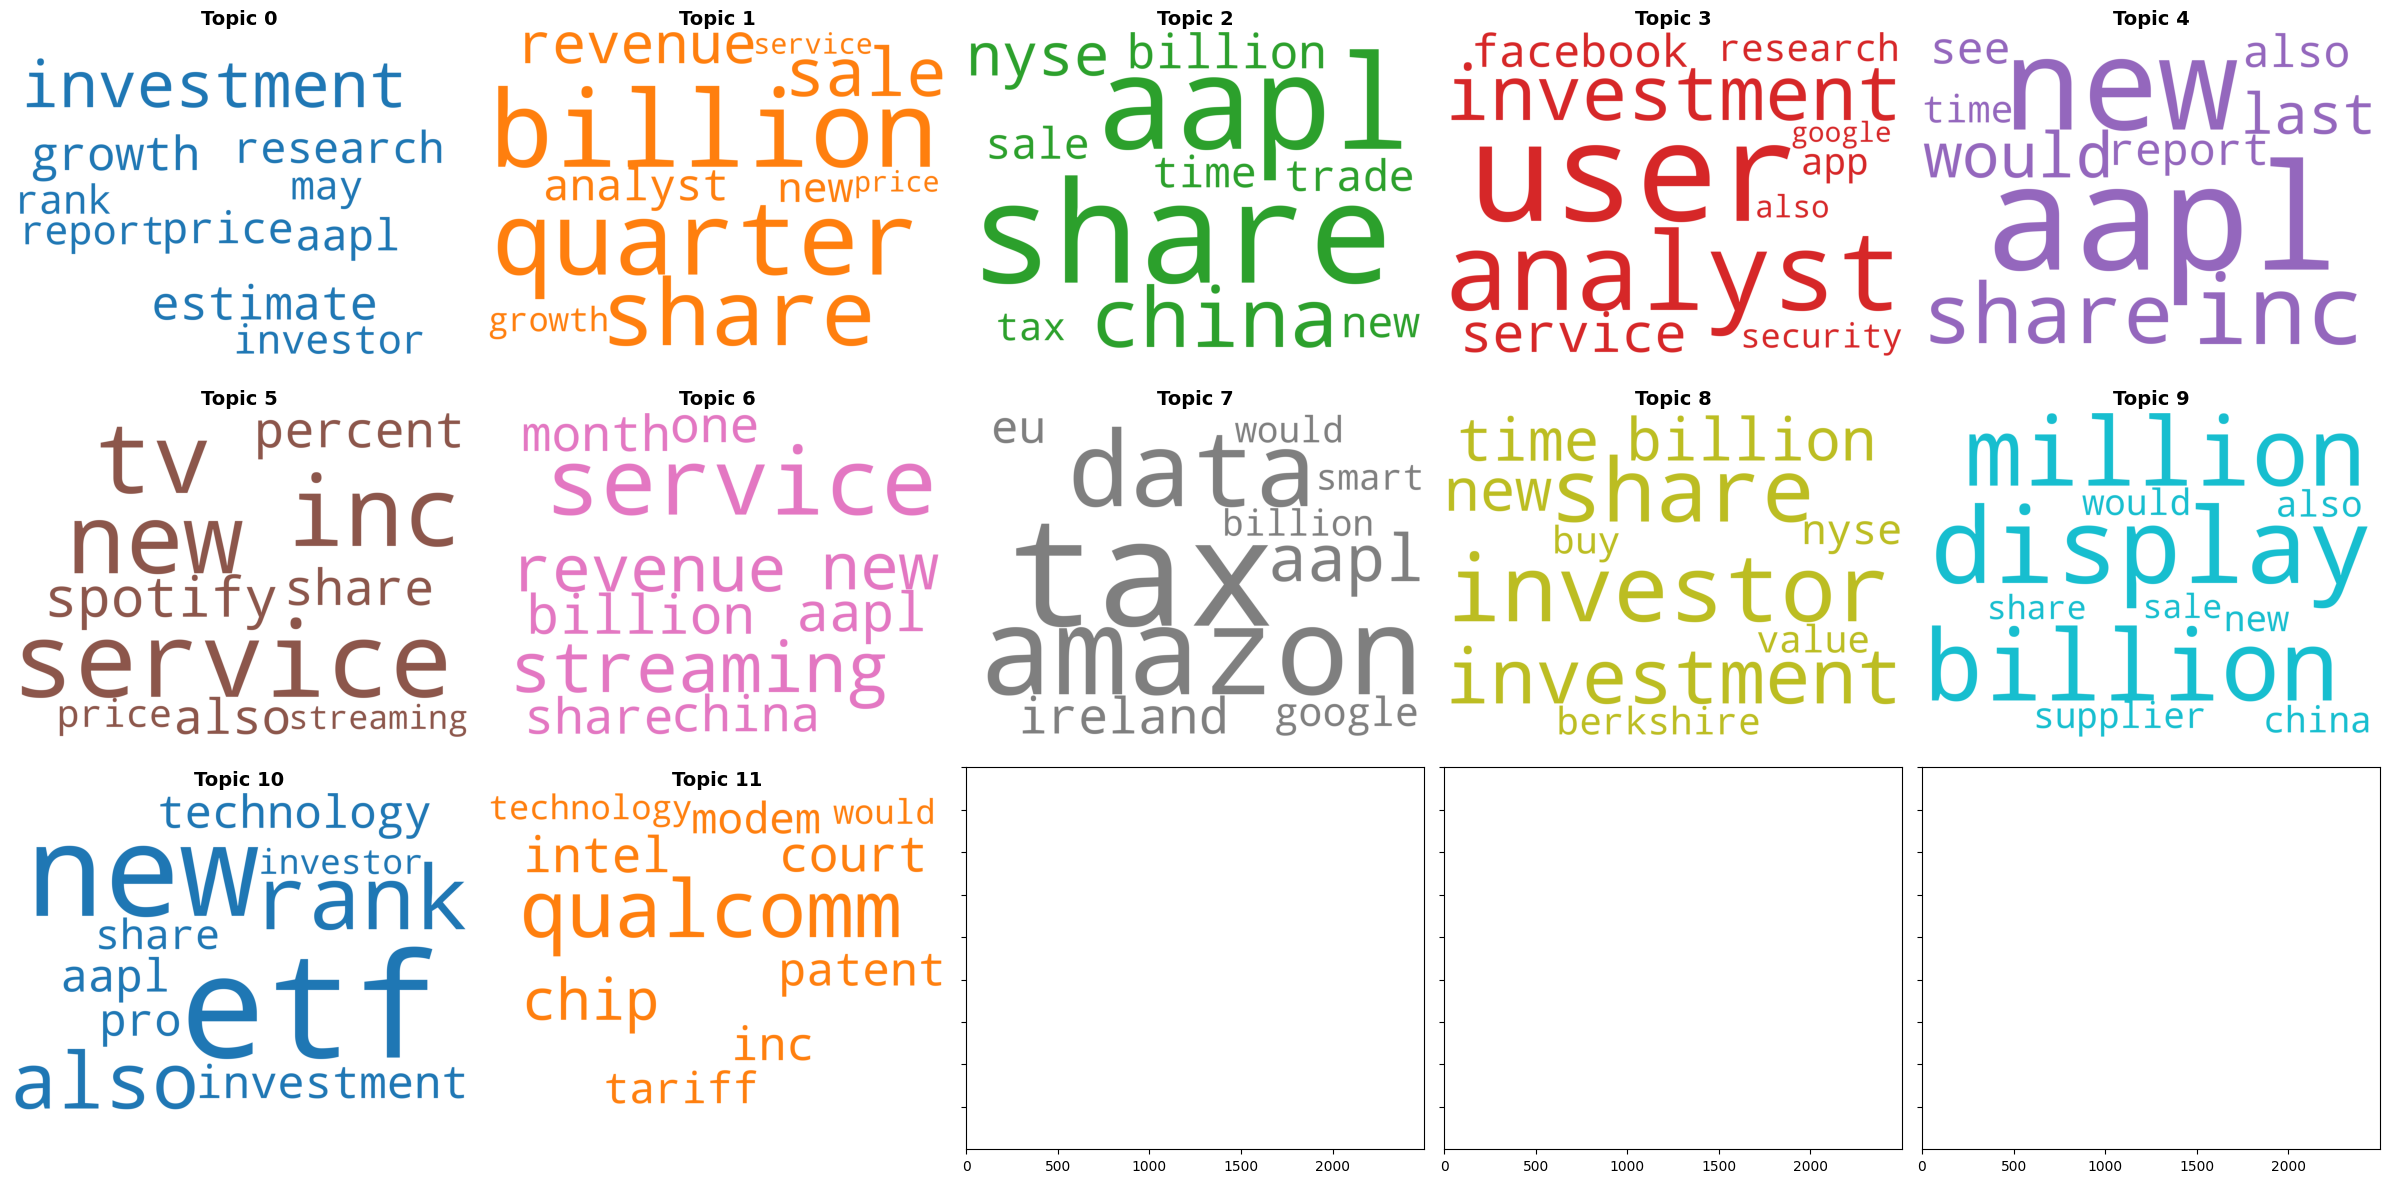

In [97]:
plot_topics(lda_model)

In [98]:
print_scores(lda_model, documents)

Coherence: 0.3643304871065205
Diversity: 0.5
Interpretability: 0.18216524355326025


#### 1.5.5.6 Iteration 6

* Our performance seems to get slightly better → so let's decrease the number of topics by `6`.

In [99]:
%%time
lda_model = create_lda_model(documents, num_topics=6)

CPU times: user 5.63 s, sys: 0 ns, total: 5.63 s
Wall time: 5.63 s


In [100]:
print_topics(lda_model)

Topic 0: [('investment', 0.013), ('growth', 0.006), ('investor', 0.005), ('aapl', 0.005), ('research', 0.005), ('estimate', 0.005), ('price', 0.005), ('rank', 0.005), ('analyst', 0.005), ('share', 0.005)]
Topic 1: [('billion', 0.011), ('quarter', 0.01), ('share', 0.01), ('revenue', 0.009), ('sale', 0.009), ('analyst', 0.008), ('new', 0.007), ('service', 0.007), ('growth', 0.006), ('also', 0.005)]
Topic 2: [('billion', 0.007), ('share', 0.006), ('tax', 0.006), ('aapl', 0.006), ('new', 0.006), ('china', 0.005), ('trump', 0.004), ('would', 0.004), ('tariff', 0.004), ('could', 0.004)]
Topic 3: [('user', 0.007), ('service', 0.006), ('new', 0.006), ('app', 0.006), ('also', 0.005), ('data', 0.005), ('google', 0.005), ('china', 0.004), ('device', 0.004), ('facebook', 0.004)]
Topic 4: [('qualcomm', 0.009), ('aapl', 0.007), ('new', 0.006), ('would', 0.006), ('inc', 0.005), ('share', 0.004), ('also', 0.004), ('last', 0.004), ('chip', 0.004), ('report', 0.004)]
Topic 5: [('service', 0.01), ('strea

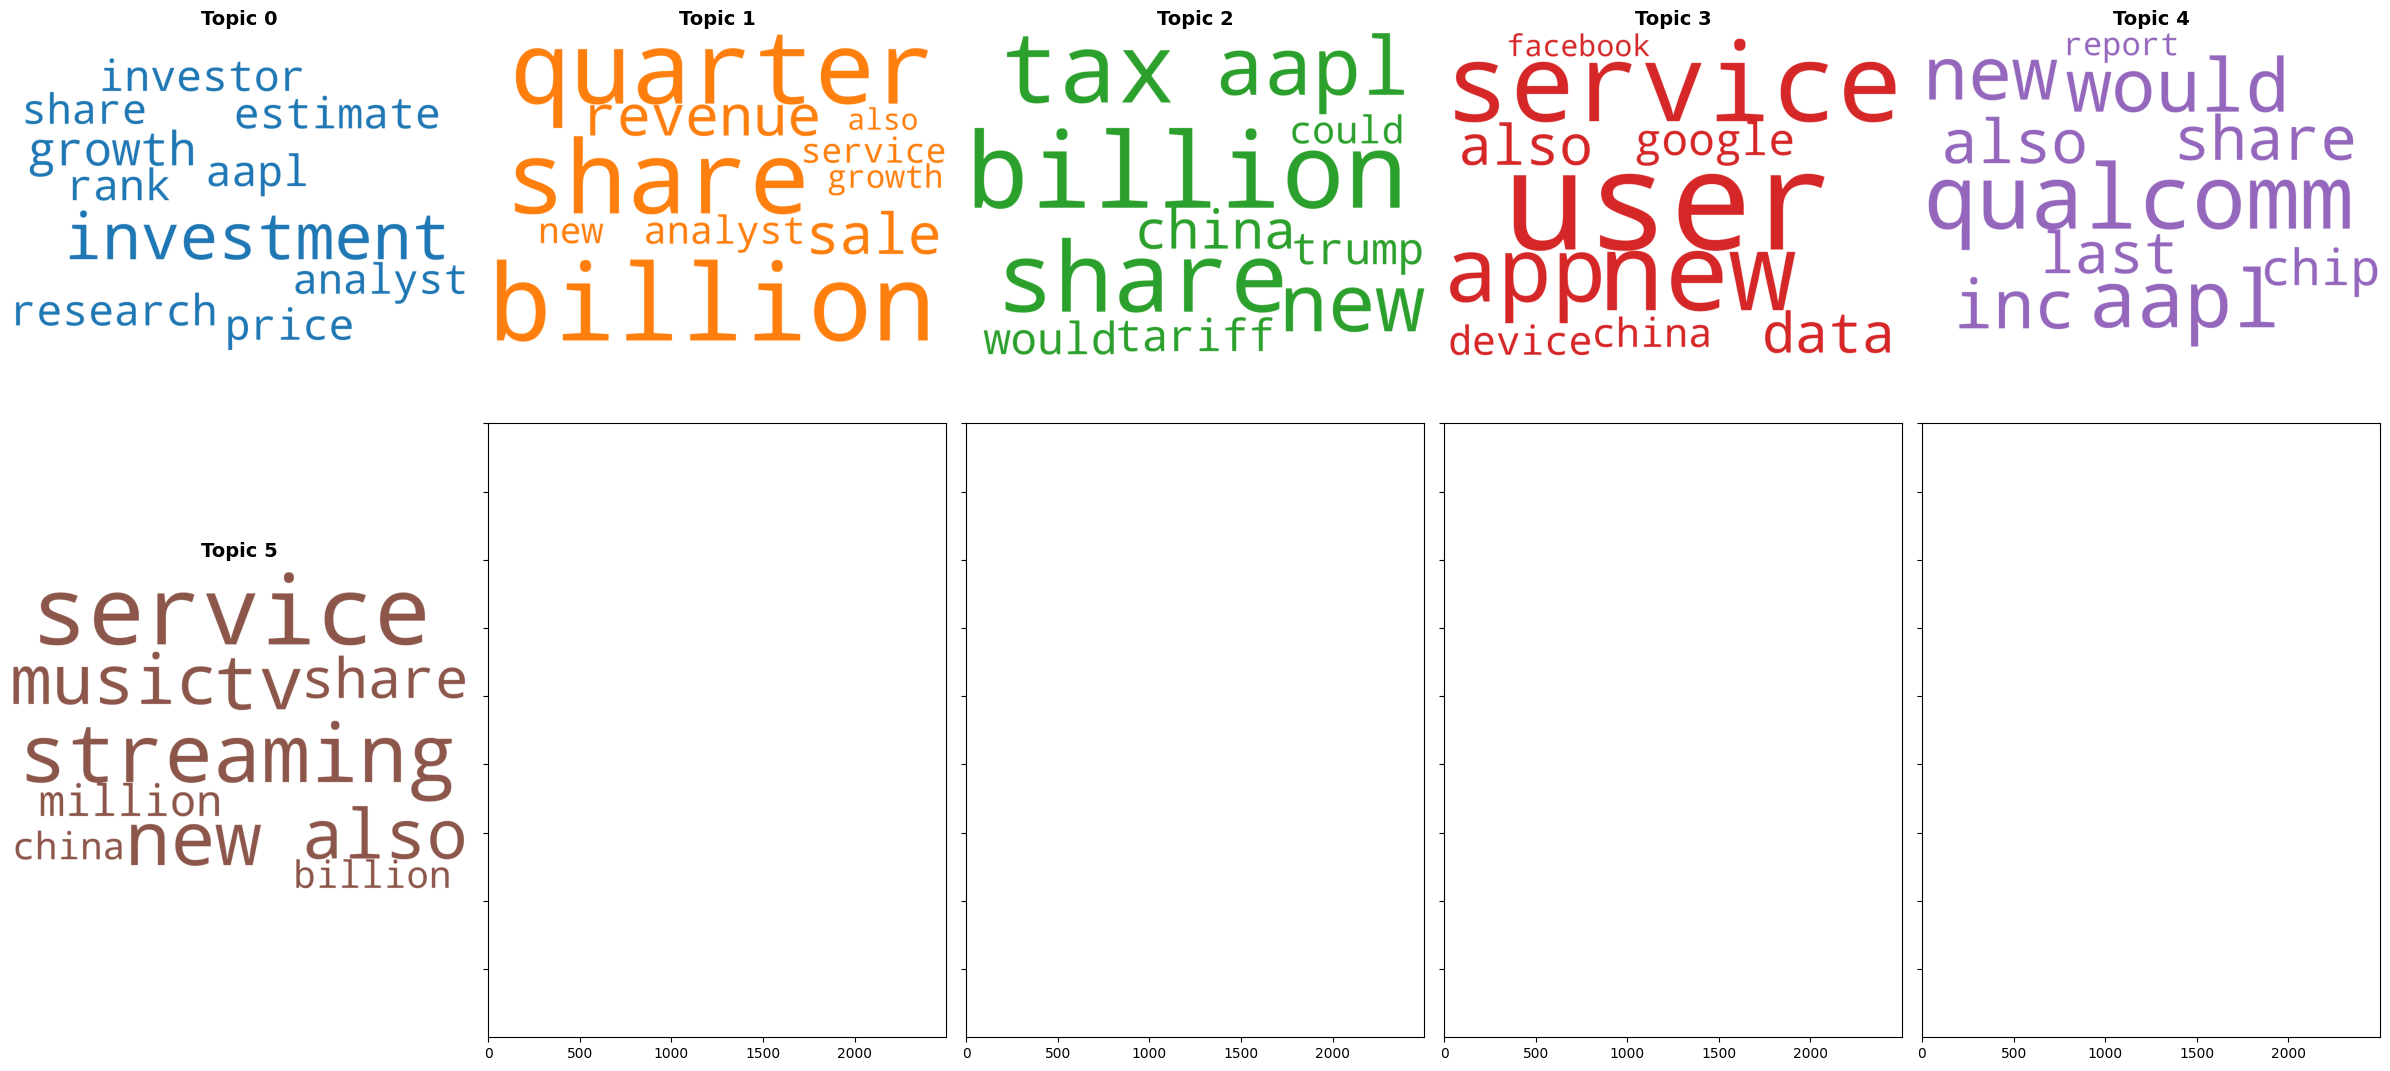

In [101]:
plot_topics(lda_model)

In [102]:
print_scores(lda_model, documents)

Coherence: 0.3693741921469554
Diversity: 0.6333333333333333
Interpretability: 0.2339369883597384


#### 1.5.5.7 Iteration 7

* [ todo ]

In [103]:
documents = remove_from_documents(documents, ["billion", "service", "new"])

In [104]:
%%time
lda_model = create_lda_model(documents, num_topics=6)

CPU times: user 5.29 s, sys: 0 ns, total: 5.29 s
Wall time: 5.29 s


In [105]:
print_topics(lda_model)

Topic 0: [('investment', 0.011), ('analyst', 0.009), ('quarter', 0.008), ('growth', 0.008), ('revenue', 0.006), ('research', 0.006), ('share', 0.006), ('estimate', 0.005), ('expected', 0.005), ('also', 0.005)]
Topic 1: [('app', 0.005), ('also', 0.005), ('data', 0.005), ('google', 0.004), ('china', 0.004), ('store', 0.004), ('inc', 0.004), ('user', 0.004), ('technology', 0.004), ('apps', 0.004)]
Topic 2: [('share', 0.008), ('price', 0.008), ('investor', 0.006), ('china', 0.005), ('sale', 0.005), ('aapl', 0.005), ('revenue', 0.005), ('last', 0.005), ('trade', 0.005), ('growth', 0.004)]
Topic 3: [('share', 0.01), ('china', 0.008), ('sale', 0.008), ('quarter', 0.007), ('million', 0.006), ('analyst', 0.006), ('revenue', 0.006), ('aapl', 0.005), ('also', 0.005), ('percent', 0.005)]
Topic 4: [('aapl', 0.008), ('revenue', 0.007), ('price', 0.006), ('share', 0.006), ('quarter', 0.005), ('also', 0.005), ('sale', 0.005), ('tv', 0.005), ('could', 0.004), ('time', 0.004)]
Topic 5: [('qualcomm', 0.0

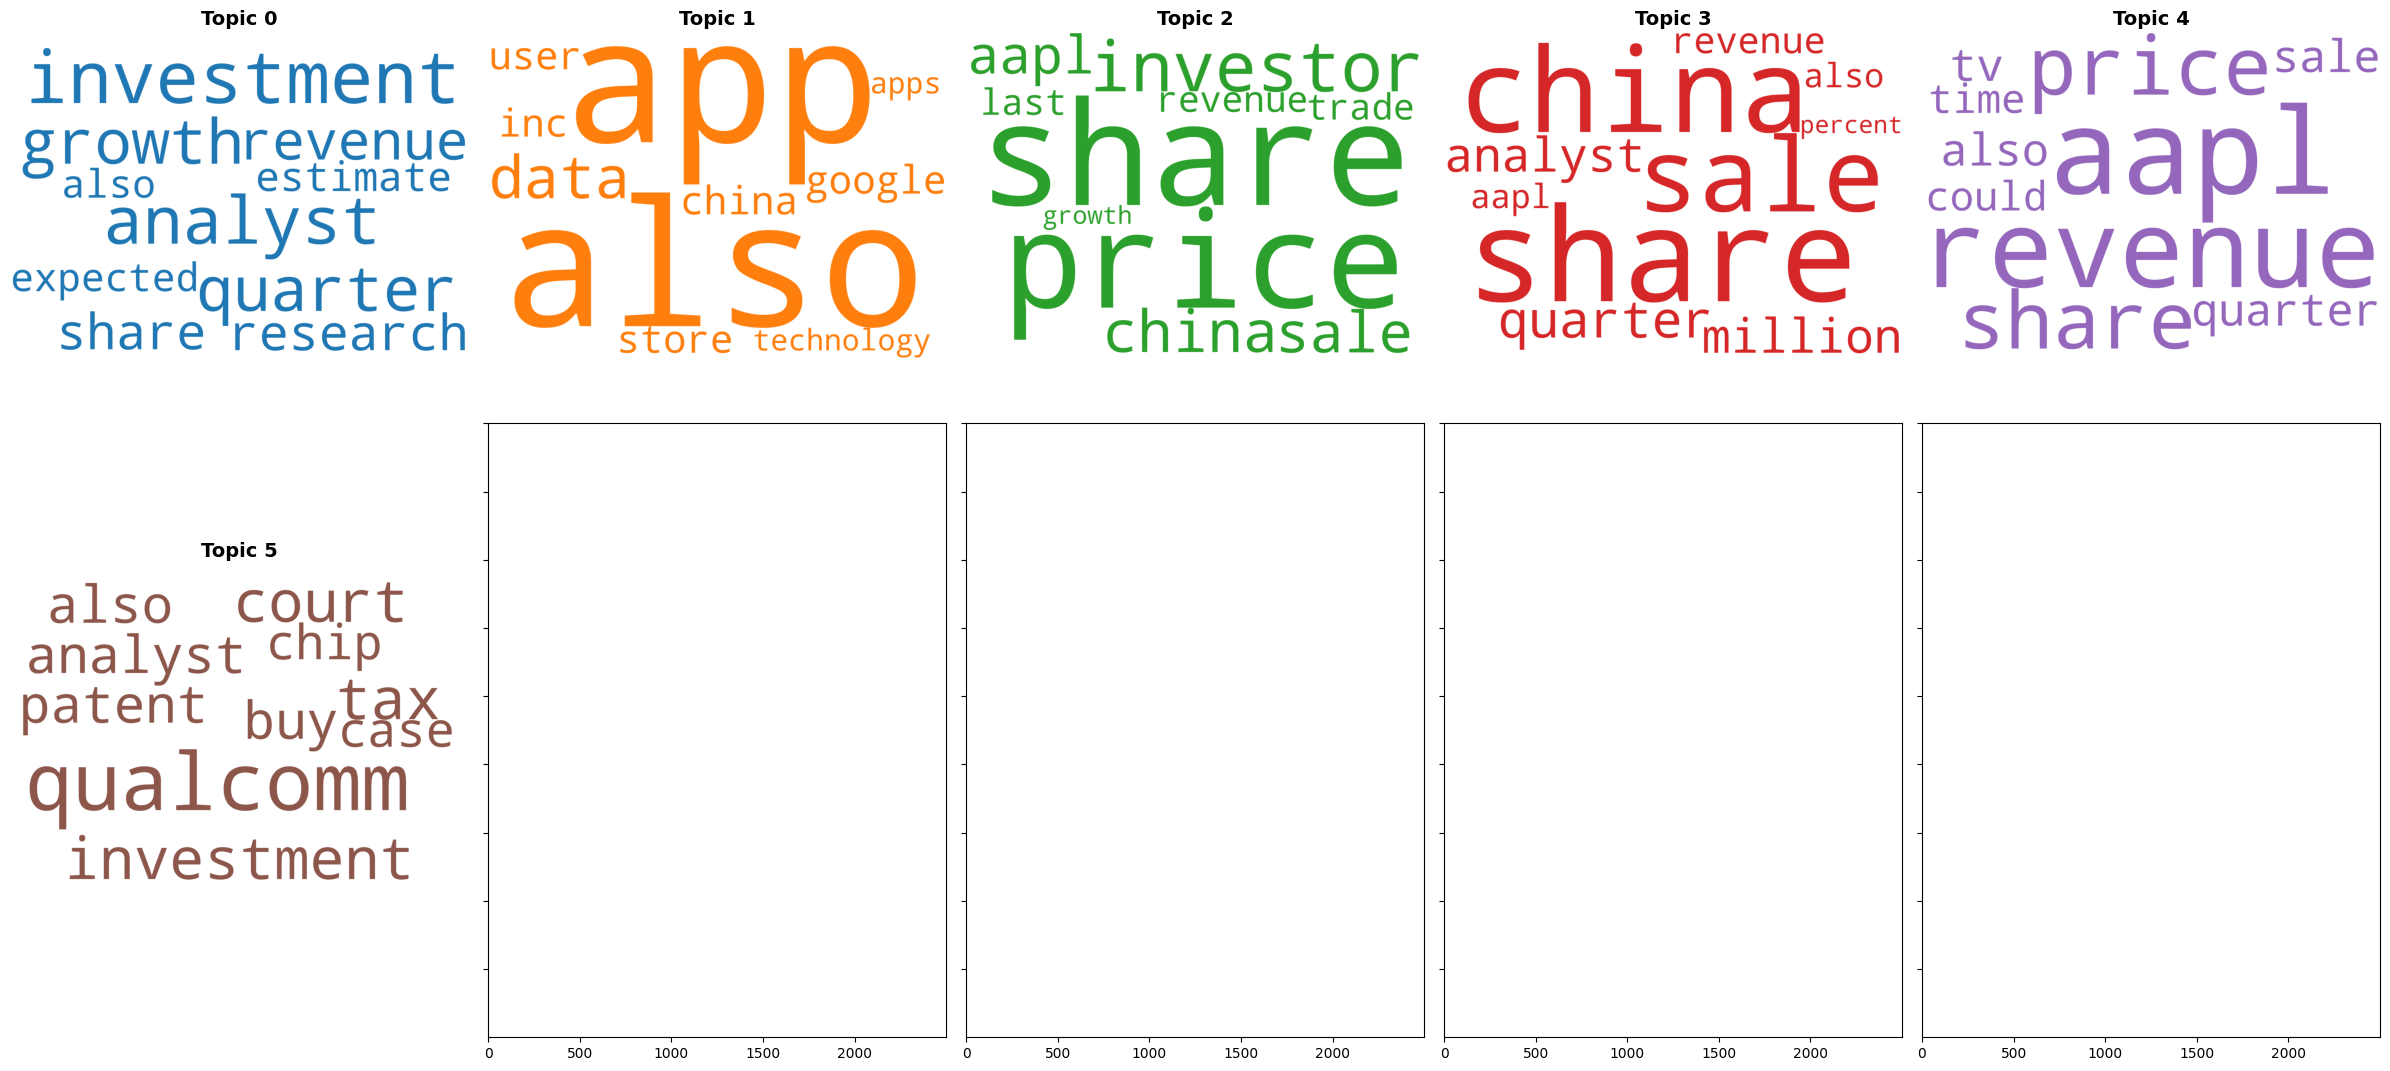

In [106]:
plot_topics(lda_model)

In [107]:
print_scores(lda_model, documents)

Coherence: 0.34181242743773527
Diversity: 0.6166666666666667
Interpretability: 0.2107843302532701


## 99. Scratch

In [108]:
# TODO(tomdewildt):
#  - [x] Select topic modeling algorithms
#  - [ ] How does the selected algorithm work?
#  - [ ] Run at least 5 iterations of the algorithm
#          - [ ] Create model
#          - [ ] Train model
#          - [ ] Assess quality (typo's, meaningless words, etc.)
#          - [ ] Update corpus (stopwords)
#          - [ ] Update parameters (nr of topics, vectorizer, etc.)
#  - [ ] Find optimal number of topics (based on judgment)
#  - [ ] Find optimal number of topics (based on metrics)
#  - [ ] Evaluate output (what metric, compare judgment and metric findings, etc.)
#  - [ ] Present output
#  - [ ] Limitations
#  - [ ] Applying to financial market